# Supervised anomaly detection

**Anomaly detection** (or **outlier detection**) comprises the **machine learning** methods aimed at identification of observations that exhibit suspicious behaviour and are very likely to cause a problem. 

This data set is provided by X, one of the largest Original Equipment Manufacturer. It regards the task of the supervised anomaly detection on a production line. For each of the produced items, a set of properties are measured, and finally a special testing procedure verifies that the item is intact. Thus, all the observations are labeled as normal or defect (anomalies), with anomalies being rare.

Statistically, this is formalized as the supervised anomaly detection, because the correct labels are given during training. This can also be seen as a task of supervised classification with two very dis-equilibrated classes.

You are suggested to construct an anomaly detection rule which, for each new observation, provides an anomaly score, that is the score is higher for more abnormal observation. This would allow to detect anomaly just based on measured parameters of the item without running a mechanical testing procedure.

## The performance criterion:

You should submit a file that contains in each row anomaly score (a real vaule) for the observation in the corresponding row of the file **xtest.csv**. For a sample submission please see the code below. Please note, that your score should provide ordering which allows to identify anomalies, i.e., the higher the value of the score, the **more abnormal** the observation should be considered.

The performance criterion is the **Area Under the Receiver Operating Characteristic** (AUC), see also:
https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve

# Data Challenge - Telecom MSBGD 2021
## Dominique Jeancler
---
## Avant propos:

Compte tenu du contexte de ce Data challenge et des résultats obtenus, il me parait important de partager en introduction une observation importante sur le jeu de données qui a mon sens **a biaisé l’exercice**.

En analysant les données, j’ai pu m’apercevoir que nous avions dans le jeu d’apprentissage un nombre aberrant statistiquement d’observation dupliquées au regard des combinaisons possible. Par ailleurs et de manière encore plus improbable, **la quasi-totalité de ces duplicats sont constitués de paires (pas de triplet ni de quadruplet) dont les réponses sont contradictoires (paire avec étiquette 0 et 1). Ces paires contradictoires constituent la moitié de notre cortège d’anomalie sur l'apprentissage.**

Considérant le contexte, j’ai supposé que ces doublons était le fruit d’une première phase de détection automatique d’anomalie chez l'équipementier suivie d’une phase de contrôle (opérateur humain ?). Ces doublons doivent être vu alors comme des faux positifs et sa forte proportion comme une volonté naturelle de qualité chez un équipementier.

**Si cette hypothèse s’avère exact, j’aurais dû considérer ces doublons comme des faux positifs et supprimer en preprocessing pour chaque paire l’observation correspondant à 1 pour améliorer le modèle de détection existant. Malheureusement, deux autres observations sur les doublons me font penser que les données ont été polluées,quu'on a une dépdance entre les données train et test et que le fait même d'être un doublon doit être considéré comme une information si on recherche de bonnes performances sur le test** :
* On observe la même quantité de doublons interne dans le jeu test > on ne peut pas supprimer de ligne sur le test avec ce format d’exercice. On peut s'attendre à ce que ces observations est la meme répartition d'anomalie. Il faut donc prendre en comtpe ce caractère en entrée pour pouvoir le reproduire en sortie.
* On observe enfin que le restant des anomalies sur le train correspondent à des doublons partagés cette fois avec le test. **Si ces doublons sont aussi des paires contradictoires, cela implique que la réponse d’un point sur le test doit être l’inverse de son image sur le train ce qui fait peu de sens en terme de modélisation mais très efficace en terme de prédiction.**

Pour expliquer la présence de ces doublons et leurs répartitions sur test et train, je ne vois d'autre explication que le fait que **les jeux de donnée test et train fournis soient en réalité un même jeu de donnée partagé en deux et contenant donc des dépendances via les doublons. L'évaluation de ce datachallenge portant sur les performance de prediction sur le test, je ne voyais donc pas d’autre alternative que d'utiliser ces dépendances bien que cela ne fasse peu de sens.** 

Ayant contacté l'équipe pédagogique pour discuter de ce point, je n'ai pas obtenu les éclaircissements nécessaire pour opter pour un méthode plus raisonnable et j'ai opté pour cette voie compte tenu du mode d'évaluation. Mais bien évidemment, **le modèle en sortie ne pourra pas afficher d'aussi bonne performance dans la réalité pour de nouvelle observation.**

## Import bibliothèque

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score,validation_curve,learning_curve,GridSearchCV
from sklearn.metrics import roc_auc_score,confusion_matrix,plot_roc_curve,roc_curve
from sklearn.metrics import classification_report,recall_score,f1_score,auc

from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures,StandardScaler,MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA

# 1 Contrôle des données et identification du problème

Dans un premier temps nous allons récupérer les données et répondre aux questions suivantes :

* Taille du jeu de données
* Présence de non valeur
* Nature du problème
* Nature des covariables

## 1.1 Taille et type du jeu de données

In [2]:
# via colab
#from google.colab import drive
#drive.mount("/content/gdrive")
#xtrain = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/xtrain.csv")
#ytrain = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/ytrain.csv")
#xtest = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/xtest.csv")

#print(xtrain.shape,ytrain.shape,xtest.shape)

In [3]:
xtrain = pd.read_csv("../data/xtrain.csv")
ytrain = pd.read_csv("../data/ytrain.csv")
xtest = pd.read_csv("../data/xtest.csv")

print(xtrain.shape,ytrain.shape,xtest.shape)

(27586, 27) (27586, 1) (27587, 27)


## 1.2 Recherche de non valeurs : 

In [4]:
def verif_null(df):
    return df.isnull().values.sum()

print(f"Il y a {verif_null(xtrain)} valeurs manquantes pour xtrain.")
print(f"Il y a {verif_null(ytrain)} valeurs manquantes pour ytrain.")
print(f"Il y a {verif_null(xtest)} valeurs manquantes pour xtest.")

Il y a 0 valeurs manquantes pour xtrain.
Il y a 0 valeurs manquantes pour ytrain.
Il y a 0 valeurs manquantes pour xtest.


## 1.3 Nature du problème :

In [5]:
print(f'{ytrain.Anomaly.value_counts()}\n{round(ytrain.mean()*100,3)} % ')

0    26893
1      693
Name: Anomaly, dtype: int64
Anomaly    2.512
dtype: float64 % 


## 1.4 Nature des variables explicatives :

In [6]:
xtrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27586 entries, 0 to 27585
Data columns (total 27 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   START2_OP020_V_1angle                      27586 non-null  float64
 1   START2_OP020_V_1torque                     27586 non-null  float64
 2   START2_OP020_V_2angle                      27586 non-null  float64
 3   START2_OP020_V_2torque                     27586 non-null  float64
 4   START2_OP040_Vision_cosseprog              27586 non-null  float64
 5   START2_OP050_Vision_paliermodel            27586 non-null  float64
 6   START2_OP050_Vision_palierpresencedouille  27586 non-null  float64
 7   START2_OP060_Vision_tirantcouleur          27586 non-null  float64
 8   START2_OP070_V_1angle                      27586 non-null  float64
 9   START2_OP070_V_1prog                       27586 non-null  float64
 10  START2_OP070_V_1torque

In [7]:
xtrain.nunique()

START2_OP020_V_1angle                         393
START2_OP020_V_1torque                         11
START2_OP020_V_2angle                         370
START2_OP020_V_2torque                          9
START2_OP040_Vision_cosseprog                  16
START2_OP050_Vision_paliermodel                 2
START2_OP050_Vision_palierpresencedouille       2
START2_OP060_Vision_tirantcouleur               2
START2_OP070_V_1angle                         959
START2_OP070_V_1prog                            2
START2_OP070_V_1torque                         16
START2_OP070_V_2angle                        1024
START2_OP070_V_2prog                            2
START2_OP070_V_2torque                         13
START2_OP080_Vision_rondelleprog                8
START2_OP090_MaxMidForceLimit                   2
START2_OP090_MinMidForceLimit                   2
START2_OP090_SnapRingFinalStroke              218
START2_OP090_SnapRingMidPointForce           5964
START2_OP090_SnapRingPeakForce               9479


## 1.5 Synthèse données :
* Taille du jeu de données et type : 27586 observations dans l'échantillon d'apprentissage et 27587 dans l'échantillon test. Les covariables sont au nombre de 27.
* Pas de non valeurs détectées.
* Nature du problème : Problème de classification binaire $y \in 0;1 $ déséquilibré $ p(y=1) = 2.512$ %
* Nature des covariables : Variables uniquement quantitatives avec un mélange continu et discret. On a notamment 8 variables binaires.


# 2 Investigation des données


In [8]:
df=pd.concat([xtrain,ytrain],axis=1)
df=df.reindex(columns = df.nunique().sort_values(ascending=False).index)
#df["ColorLegend"]=df["Anomaly"].apply(lambda x : "Anomalie" if x == 1 else "Sain")
df.nunique()

START2_OP090_SnapRingPeakForce               9479
START2_OP090_SnapRingMidPointForce           5964
START2_OP090_StartLinePeakForce              5268
START2_OP120_RodageI_mesure                  4116
START2_OP070_V_2angle                        1024
START2_OP070_V_1angle                         959
START2_OP110_Vissage_M8angle                  693
START2_OP020_V_1angle                         393
START2_OP020_V_2angle                         370
START2_OP090_SnapRingFinalStroke              218
START2_OP110_Vissage_M8torque                  80
START2_OP120_RodageU_mesure                    63
START2_OP100_Capuchon_insertionmesure          27
START2_OP040_Vision_cosseprog                  16
START2_OP070_V_1torque                         16
START2_OP070_V_2torque                         13
START2_OP020_V_1torque                         11
START2_OP020_V_2torque                          9
START2_OP080_Vision_rondelleprog                8
START2_OP070_V_2prog                            2


In [9]:
def correl_plot(df,titre='Matrice corrélation variables'):
    
    plt.figure(figsize=[10,df.shape[1]/2])
    plt.title(titre)
    mask = np.zeros((df.shape[1],df.shape[1]))
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(df.corr()*100,annot=True,linewidths=.5,fmt='.1f',mask=mask)
    plt.xticks(size=8)
    plt.show()
    plt.close();
    
def boxplot(df):
    
    plt.figure(figsize=[15,int(np.ceil(df.shape[1]/3))*4])
    for x in range(df.shape[1]-1):
        plt.subplot(int(np.ceil(df.shape[1]/3)),3,x+1)
        col=df.iloc[:,x].name
        sns.boxplot(x='Anomaly',y=col,data=df)
        plt.title(col)
        plt.gcf().subplots_adjust(wspace = 0.3, hspace = 0.3)
    plt.close;
        
def hist_binaire(df):
    
    plt.figure(figsize=[15,int(np.ceil(df.shape[1]/3))*4])
    for x in range(df.shape[1]-1):

        plt.subplot(int(np.ceil(df.shape[1]/3)),3,x+1)
        plt.hist([df.iloc[:,x][df.Anomaly==0],
                  df.iloc[:,x][df.Anomaly==1]],density = True
                ,label = ['Sain', 'Anomalique'],bins=2)
        plt.title(df.iloc[:,x].name)
        plt.xlabel('valeurs')
        plt.ylabel('frequence')
        plt.legend()
        plt.gcf().subplots_adjust(wspace = 0.3, hspace = 0.3);
        
    
    plt.figure(figsize=[15,int(np.ceil(df.shape[1]/3))*4])
    for x in range(df.shape[1]-1):

        plt.subplot(int(np.ceil(df.shape[1]/3)),3,x+1)
        plt.hist(df.iloc[:,x],bins=2,color = 'green',edgecolor = 'black')
        plt.title(df.iloc[:,x].name)
        plt.xlabel('valeurs')
        plt.ylabel('count')
        plt.gcf().subplots_adjust(wspace = 0.3, hspace = 0.3);
    plt.close;
        
def hist(df,b='auto'):
    
    plt.figure(figsize=[15,int(np.ceil(df.shape[1]/3))*4])
    for x in range(df.shape[1]-1):

        plt.subplot(int(np.ceil(df.shape[1]/3)),3,x+1)
        plt.hist([df.iloc[:,x][df.Anomaly==0],
                  df.iloc[:,x][df.Anomaly==1]],density = True
                ,label = ['Sain', 'Anomalique'],bins=b)
        plt.title(df.iloc[:,x].name)
        plt.xlabel('valeurs')
        plt.ylabel('frequence')
        plt.legend()
        plt.gcf().subplots_adjust(wspace = 0.3, hspace = 0.3);
    plt.close;
    
        
def plot_dist(df,start=0,stop=df.shape[1]):

    liste = df.iloc[:,start:stop].columns
    a=int((stop-start) + ((stop-start) % (1 if (stop-start) >= 0 else -1)))
    
    i=0
    plt.figure(figsize=[20,4*a])
    for col in liste:
        if col == "Anomaly" :
            continue
        i=i+1
        if df[col].nunique() > 100 :
            b= 50
        else :
            b= 30
        plt.subplot(a,3,i)
        sns.histplot(df[df.Anomaly==0][col],label='Sain',bins=b,stat='density',kde=True) #histplot au lieu de distplot
        sns.histplot(df[df.Anomaly==1][col],label='Anomalique',bins=b,color='orange',stat='density',kde=True) #histplot au lieu de distplot
        plt.legend(['Sain','Anomalique'])
        plt.gcf().subplots_adjust(wspace = 0.3, hspace = 0.3) # {“count”, “frequency”, “density”, “probability”}
        
    plt.close;
    
def abberrante(df):
    return df.describe(percentiles=[.01,.05,.95,.99])[3:]
        

## 2.1 Variables binaires :



In [10]:
df_binaire=df[df.columns[df.nunique()==2]].copy()

### 2.1.1 Corrélation

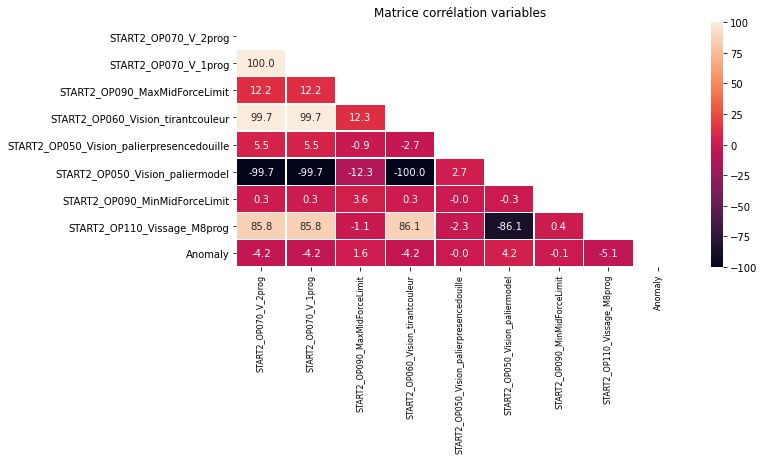

In [11]:
correl_plot(df_binaire)

In [12]:
df_binaire[["START2_OP070_V_2prog","START2_OP070_V_1prog",
            "START2_OP050_Vision_paliermodel","START2_OP060_Vision_tirantcouleur"]].head()

,START2_OP070_V_2prog,START2_OP070_V_1prog,START2_OP050_Vision_paliermodel,START2_OP060_Vision_tirantcouleur
0,8.0,8.0,1.0,2.0
1,8.0,8.0,1.0,2.0
2,8.0,8.0,1.0,2.0
3,7.0,7.0,2.0,1.0
4,8.0,8.0,1.0,2.0


**Observations :** 
* On a une parfaite corrélation entre START2_OP070_V_2prog et START2_OP070_V_1prog 
* On a une parfaite anticorrélation entre START2_OP050_Vision_paliermodel et START2_OP060_Vision_tirantcouleur
* On a une très forte crrélation entre START2_OP060_Vision_tirantcouleur et START2_OP070_V_1prog qui semble être une translation par 6

Investigons la relation entre START2_OP060_Vision_tirantcouleur et START2_OP070_V_1prog (translation 6).

In [13]:
diff=(df_binaire["START2_OP070_V_1prog"]-6!=df_binaire["START2_OP060_Vision_tirantcouleur"]).sum()
print(f'Il y a {diff} observations qui sortent de la relation.')

Il y a 41 observations qui sortent de la relation.


In [14]:
df_binaire=df[df.columns[df.nunique()==2]].drop(columns=['START2_OP060_Vision_tirantcouleur',
                                                         'START2_OP050_Vision_paliermodel',
                                                         'START2_OP070_V_2prog'])

### 2.1.2 Relation à $y$
On regarde la répartition de chacune de ces variables et lien avec $y$

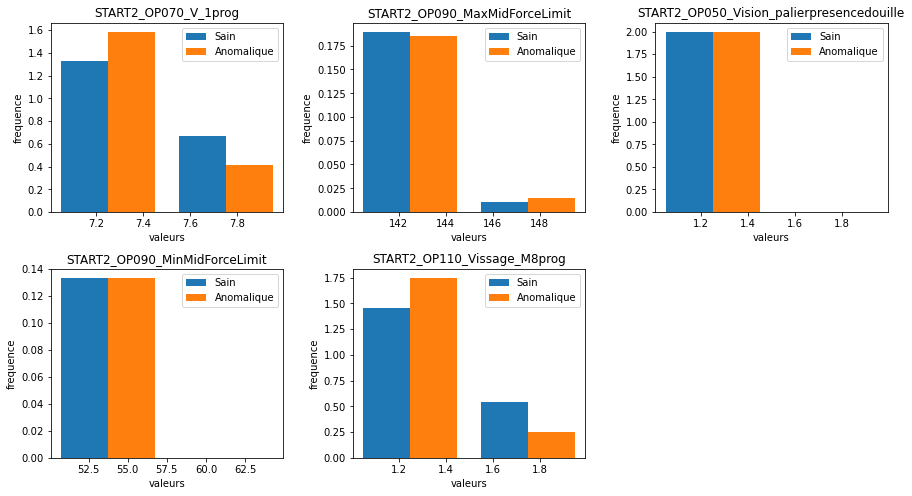

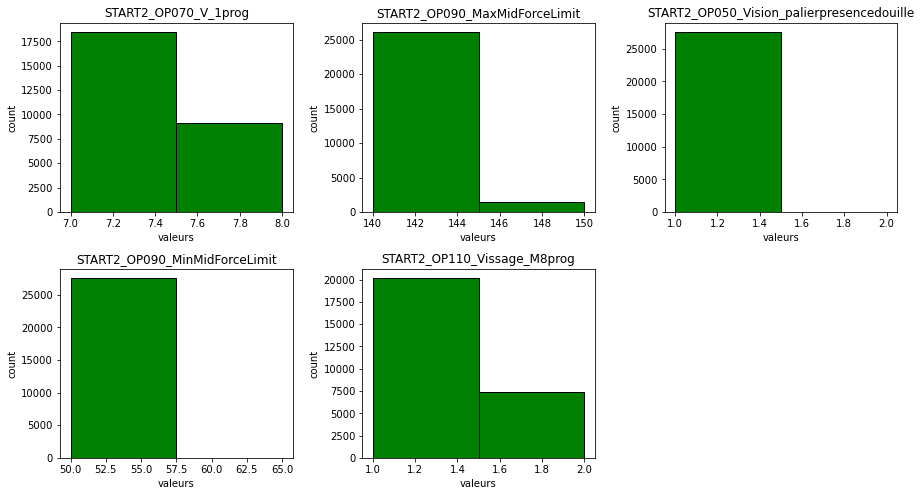

In [15]:
hist_binaire(df_binaire)

In [16]:
print(f"Rappel : pourcentage d'échantillon anomalique {round(sum(df['Anomaly'])*100/df.shape[0],3)} % \n")

def stat_cat(df): 
    for i in range(df.shape[1]):
        print(f'{df.iloc[:,i].name} :')
        print (f'répartition échantillons \t min ({df.iloc[:,i].min()}) > {round(df[df.iloc[:,i]==df.iloc[:,i].min()].shape[0]*100/df.shape[0],3)}% min ({df.iloc[:,i].max()}) > {round(df[df.iloc[:,i]==df.iloc[:,i].max()].shape[0]*100/df.shape[0],3)}% ')
        print (f'pourcentage anomalique   \t min ({df.iloc[:,i].min()}) > {round(df[df.iloc[:,i]==df.iloc[:,i].min()]["Anomaly"].sum()*100/df[df.iloc[:,i]==df.iloc[:,i].min()].shape[0],3)}% max ({df.iloc[:,i].max()}) > {round(df[df.iloc[:,i]==df.iloc[:,i].max()]["Anomaly"].sum()*100/df[df.iloc[:,i]==df.iloc[:,i].max()].shape[0],2)}%')
    
stat_cat(df_binaire)

Rappel : pourcentage d'échantillon anomalique 2.512 % 

START2_OP070_V_1prog :
répartition échantillons 	 min (7.0) > 66.907% min (8.0) > 33.093% 
pourcentage anomalique   	 min (7.0) > 2.974% max (8.0) > 1.58%
START2_OP090_MaxMidForceLimit :
répartition échantillons 	 min (140.0) > 94.715% min (150.0) > 5.285% 
pourcentage anomalique   	 min (140.0) > 2.453% max (150.0) > 3.57%
START2_OP050_Vision_palierpresencedouille :
répartition échantillons 	 min (1.0) > 99.851% min (2.0) > 0.149% 
pourcentage anomalique   	 min (1.0) > 2.512% max (2.0) > 2.44%
START2_OP090_MinMidForceLimit :
répartition échantillons 	 min (50.0) > 99.993% min (65.0) > 0.007% 
pourcentage anomalique   	 min (50.0) > 2.512% max (65.0) > 0.0%
START2_OP110_Vissage_M8prog :
répartition échantillons 	 min (1.0) > 73.298% min (2.0) > 26.702% 
pourcentage anomalique   	 min (1.0) > 2.997% max (2.0) > 1.18%
Anomaly :
répartition échantillons 	 min (0) > 97.488% min (1) > 2.512% 
pourcentage anomalique   	 min (0) > 0.0% 

In [17]:
# Focus sur les variables très désiquilibrées
print(f"Pour START2_OP090_MinMidForceLimit {df[df['START2_OP090_MinMidForceLimit']==65].shape[0]} observations sortent de la constante")
print(f'elles contiennent {df[df["START2_OP090_MinMidForceLimit"]==65]["Anomaly"].sum()} anomalies')
print(f"Pour START2_OP050_Vision_palierpresencedouille {df[df['START2_OP050_Vision_palierpresencedouille']==2].shape[0]} observations sortent de la constante")
print(f'elles contiennent {df[df["START2_OP050_Vision_palierpresencedouille"]==2]["Anomaly"].sum()} anomalies')

Pour START2_OP090_MinMidForceLimit 2 observations sortent de la constante
elles contiennent 0 anomalies
Pour START2_OP050_Vision_palierpresencedouille 41 observations sortent de la constante
elles contiennent 1 anomalies


**Observations :**

* Parmi les variables explicatives binaires, on observe 2 variables particulièrement déséquilibrées : 

    * la variable "START2_OP090_MinMidForceLimit" : 2 échantillons uniquement différents du reste du train set totalement sain. L'utilisation faussera les regles de décisions puisque 100% des observations avec START2_OP090_MinMidForceLimit=65 sont sain.
    * la variable "START2_OP050_Vision_palierpresencedouille" : 41 échantillons uniquement différents du reste du train set avec une seule anomalie.

L'échantillonage pour ces deux variables n'est pas représentatif, on choisit de ne pas utiliser ces variables.

### 2.1.4 Conclusions :

On ne sélectionne que 3 variable binaires dans le jeu initial à savoir :
* START2_OP070_V_1prog
* START2_OP090_MaxMidForceLimit
* START2_OP110_Vissage_M8prog

Ces variables, bien que binaires, ne sont pas sur la meme échelle on va les repasser sur une échelle 0,1. 

La variable START2_OP090_MaxMidForceLimit apporte peu d'information par rapport à $y$ et est très désiquilibrée.

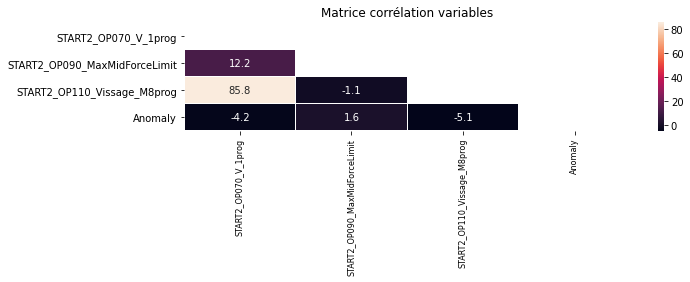

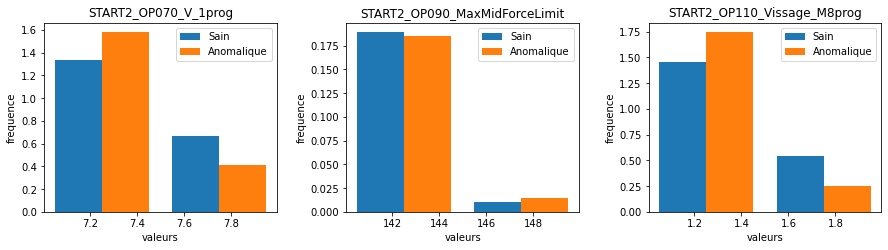

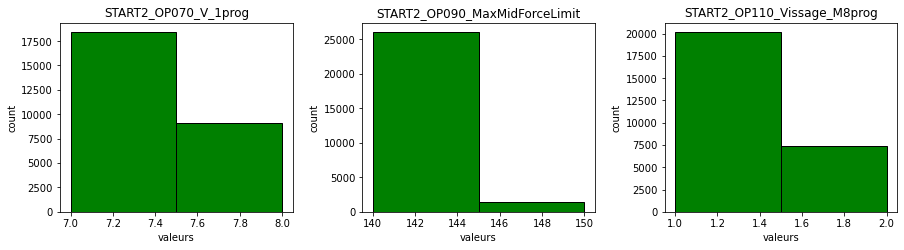

In [18]:
df_binaire=df[df.columns[df.nunique()==2]].drop(columns=['START2_OP060_Vision_tirantcouleur',
                                                         'START2_OP050_Vision_paliermodel',
                                                         'START2_OP070_V_2prog',
                                                         'START2_OP090_MinMidForceLimit',
                                                         'START2_OP050_Vision_palierpresencedouille'])
correl_plot(df_binaire)
hist_binaire(df_binaire)

In [19]:
print(df.START2_OP090_MaxMidForceLimit.value_counts())
df[df.START2_OP090_MaxMidForceLimit==150]["Anomaly"].describe()

140.0    26128
150.0     1458
Name: START2_OP090_MaxMidForceLimit, dtype: int64


count    1458.000000
mean        0.035665
std         0.185518
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: Anomaly, dtype: float64

In [20]:
def preprocess_binaire(df):
    """
    Elimination des varibales redondantes et de celles avec peu de variance
    Normalisation 0 - 1
    """
    Xclean=df.copy()
    Xclean=Xclean.drop(columns=['START2_OP060_Vision_tirantcouleur',
                           'START2_OP050_Vision_paliermodel',
                           'START2_OP070_V_2prog',
                           'START2_OP090_MinMidForceLimit', 
                           'START2_OP050_Vision_palierpresencedouille'])
    Xclean.START2_OP070_V_1prog = Xclean.START2_OP070_V_1prog-7
    Xclean.START2_OP090_MaxMidForceLimit = Xclean.START2_OP090_MaxMidForceLimit / 10 - 14 
    Xclean.START2_OP110_Vissage_M8prog=Xclean.START2_OP110_Vissage_M8prog - 1
    return Xclean

## 2.2 Variables continues avec peu de résolution

Après avoir eplxoré les variables binaires, on regarde les variables ayant peu de résolution (nunique() < 25).

In [21]:
df_faibleres=pd.concat([df[df.columns[(df.nunique()< 25)&(df.nunique()>2)]],ytrain],axis=1)

### 2.2.1 Recherche de valeurs aberrantes

In [22]:
abberrante(df_faibleres)

,START2_OP040_Vision_cosseprog,START2_OP070_V_1torque,START2_OP070_V_2torque,START2_OP020_V_1torque,START2_OP020_V_2torque,START2_OP080_Vision_rondelleprog,Anomaly
min,3.0,6.40,6.39,3.75,3.75,3.0,0.0
1%,3.0,6.40,6.40,3.75,3.75,3.0,0.0
5%,30.0,6.40,6.40,3.75,3.76,3.0,0.0
50%,700.0,6.42,6.42,3.77,3.77,7.0,0.0
95%,1300.0,6.63,6.61,3.81,3.80,13.0,0.0
99%,1300.0,6.64,6.63,3.81,3.81,13.0,1.0
max,1500.0,6.67,6.65,3.85,3.83,15.0,1.0


**Observation :** 

Pas de valeurs aberrantes mais on observe deux variables discrètes START2_OP040_Vision_cosseprog et START2_OP080_Vision_rondelleprog.

### 2.2.2 Corrélation entre covariables

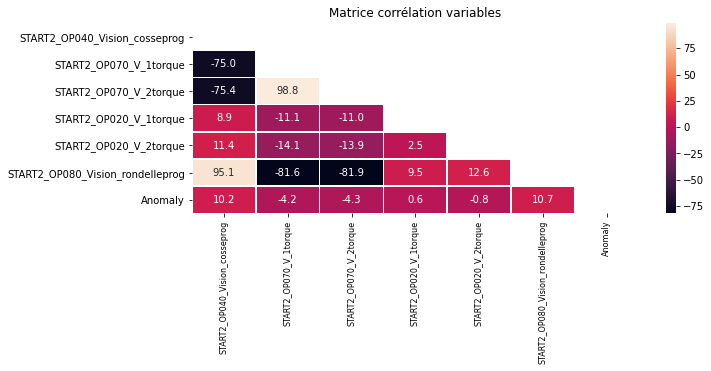

In [23]:
correl_plot(df_faibleres)

On va regarder les variables START2_OP070_V_1torque, START2_OP070_V_2torque ainsi que START2_OP040_Vision_cosseprog, START2_OP080_Vision_rondelleprog qui expriment une forte corrélation.

#### 2.2.1.a START2_OP070_V_1torque vs START2_OP070_V_2torque

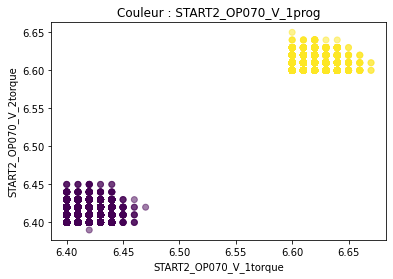

In [24]:
plt.scatter(df_faibleres.START2_OP070_V_1torque,df_faibleres.START2_OP070_V_2torque,
            c=df.START2_OP070_V_1prog,alpha=0.5)
plt.title("Couleur : START2_OP070_V_1prog")
plt.xlabel('START2_OP070_V_1torque')
plt.ylabel('START2_OP070_V_2torque');

On voit que ces variables décrivent une distribution bimodale centrée sur 6.42 et 6.62. L'appartenance à un mode ou l'autre semble par ailleurs correspondre à la variable binaire "START2_OP070_V_1prog". Vérifions.

In [25]:
df_qc1=pd.concat([df_faibleres.START2_OP070_V_1torque,df_faibleres.START2_OP070_V_2torque,df.START2_OP070_V_1prog,df_faibleres.Anomaly],axis=1)
df_qc1[df_qc1.START2_OP070_V_1prog==7].describe(percentiles=[])

,START2_OP070_V_1torque,START2_OP070_V_2torque,START2_OP070_V_1prog,Anomaly
count,18457.000000,18457.000000,18457.0,18457.000000
mean,6.416969,6.412631,7.0,0.029745
std,0.010938,0.010149,0.0,0.169887
min,6.400000,6.390000,7.0,0.000000
50%,6.420000,6.410000,7.0,0.000000
max,6.470000,6.450000,7.0,1.000000


In [26]:
df_qc1[df_qc1.START2_OP070_V_1prog==8].describe(percentiles=[])

,START2_OP070_V_1torque,START2_OP070_V_2torque,START2_OP070_V_1prog,Anomaly
count,9129.000000,9129.000000,9129.0,9129.000000
mean,6.618851,6.606539,8.0,0.015774
std,0.012022,0.008400,0.0,0.124607
min,6.600000,6.600000,8.0,0.000000
50%,6.620000,6.600000,8.0,0.000000
max,6.670000,6.650000,8.0,1.000000


On observe :
1. confirmation du lien avec la variable binaire OP070_V_1prog
2. **on a sensiblement moins d'anomalie quand OP070_V_1prog est égale à 8** i.e.OP0_V_1torque ou V2torque dans l'intervalle 6.6 6.67.

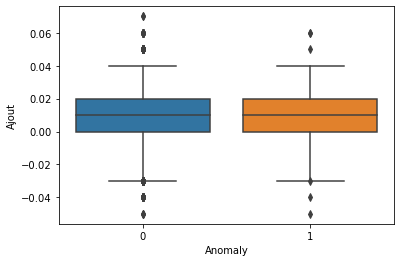

In [27]:
#On teste ici pour voir si la différence entre ces 2 variables est discriminante
df_qc1["Ajout"]=(df_qc1.START2_OP070_V_1torque-df_qc1.START2_OP070_V_2torque)
sns.boxplot(x='Anomaly',y="Ajout",data=df_qc1);

La différence entre ces 2 variables ne discrimine pas les anomalies, nous ne voyons donc pas d'intérêt à créer une nouvelle variable. 
On peut retirer une des 2 variables entre START2_OP070_V_1torque,START2_OP070_V_2torque en privilégiant la plus grande discriminante vis à vis de y.

#### 2.2.1.b START2_OP040_Vision_cosseprog vs START2_OP080_Vision_rondelleprog

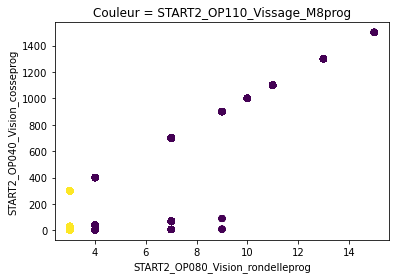

In [28]:
plt.scatter(df_faibleres.loc[:,"START2_OP080_Vision_rondelleprog"],
            df_faibleres.loc[:,"START2_OP040_Vision_cosseprog"],
           c=df.loc[:,"START2_OP110_Vissage_M8prog"])
plt.title("Couleur = "+df.loc[:,"START2_OP110_Vissage_M8prog"].name)
plt.xlabel("START2_OP080_Vision_rondelleprog")
plt.ylabel("START2_OP040_Vision_cosseprog");

In [29]:
df_qc2=df[["START2_OP040_Vision_cosseprog","START2_OP080_Vision_rondelleprog","Anomaly","START2_OP110_Vissage_M8prog"]]
df_qc2.head(4)

,START2_OP040_Vision_cosseprog,START2_OP080_Vision_rondelleprog,Anomaly,START2_OP110_Vissage_M8prog
0,300.0,3.0,0,2.0
1,30.0,3.0,0,2.0
2,300.0,3.0,0,2.0
3,1000.0,10.0,0,1.0


Observations - Hypothèses : 
* Ces deux variables sont discrètes.
* START2_OP040_Vision_cosseprog / START2_OP080_Vision_rondelleprog décrivent 3 fonctions linéaire avec un facteur multiplicatif 1,10 est 100. Sauf lorsque START2_OP080_Vision_rondelleprog est supérieur ou égale à 10.
* la variable binaire START2_OP110_Vissage_M8prog est entièrement contrôlée par START2_OP080_Vision_rondelleprog. Si START2_OP080_Vision_rondelleprog = 3 alors START2_OP110_Vissage_M8prog = 2 ; 1 sinon 

Vérifions : 

In [30]:
# On vérifie si il existe des points qui échappe à ces 3 relations linéaires
df_qc2[(df_qc2["START2_OP080_Vision_rondelleprog"]*100!=df_qc2["START2_OP040_Vision_cosseprog"])
      &(df_qc2["START2_OP080_Vision_rondelleprog"]*10!=df_qc2["START2_OP040_Vision_cosseprog"])
     &(df_qc2["START2_OP080_Vision_rondelleprog"]!=df_qc2["START2_OP040_Vision_cosseprog"])]

,START2_OP040_Vision_cosseprog,START2_OP080_Vision_rondelleprog,Anomaly,START2_OP110_Vissage_M8prog


In [31]:
# Ces différents régimes ont il un lien avec les points anomaliques ?
print("Pourcentage de point anomalique en fonction des relations :")
print(f' > rapport 100 : {round(df_qc2[df_qc2["START2_OP080_Vision_rondelleprog"]*100==df_qc2["START2_OP040_Vision_cosseprog"]].Anomaly.mean()*100,2)}%')
print(f' > rapport  10 : {round(df_qc2[df_qc2["START2_OP080_Vision_rondelleprog"]*10==df_qc2["START2_OP040_Vision_cosseprog"]].Anomaly.mean()*100,2)}%')
print(f' > rapport   1 : {round(df_qc2[df_qc2["START2_OP080_Vision_rondelleprog"]*1==df_qc2["START2_OP040_Vision_cosseprog"]].Anomaly.mean()*100,2)}%')

Pourcentage de point anomalique en fonction des relations :
 > rapport 100 : 2.64%
 > rapport  10 : 1.25%
 > rapport   1 : 1.44%


In [32]:
print("Nombre de point anomalique en fonction des relations :")
print("> rapport 100 :",sum(df_qc2["START2_OP080_Vision_rondelleprog"]*100==df_qc2["START2_OP040_Vision_cosseprog"]))
print("> rapport 10 :",sum(df_qc2["START2_OP080_Vision_rondelleprog"]*10==df_qc2["START2_OP040_Vision_cosseprog"]))
print("> rapport 1:",sum(df_qc2["START2_OP080_Vision_rondelleprog"]*1==df_qc2["START2_OP040_Vision_cosseprog"]))

Nombre de point anomalique en fonction des relations :
> rapport 100 : 24802
> rapport 10 : 1674
> rapport 1: 1110


In [33]:
#Vérifions pour la valeur seuil qui fait basculer le régime START2_OP080_Vision_rondelleprog > 9 uniquement * 100
df_qc2[df_qc2.START2_OP080_Vision_rondelleprog >= 10].describe(percentiles=[])

,START2_OP040_Vision_cosseprog,START2_OP080_Vision_rondelleprog,Anomaly,START2_OP110_Vissage_M8prog
count,11292.000000,11292.000000,11292.000000,11292.0
mean,1209.484591,12.094846,0.044368,1.0
std,131.926113,1.319261,0.205920,0.0
min,1000.000000,10.000000,0.000000,1.0
50%,1300.000000,13.000000,0.000000,1.0
max,1500.000000,15.000000,1.000000,1.0


**Observation :** 

La valeur seuil sur START2_OP080_Vision_rondelleprog 10 est très discriminante puisqu'elle double le pourcentage d'anomalie sur la moitié de l'ensemble des données.

In [34]:
df_qc2[(df_qc2['START2_OP080_Vision_rondelleprog']==3)].describe()[3::4]

,START2_OP040_Vision_cosseprog,START2_OP080_Vision_rondelleprog,Anomaly,START2_OP110_Vissage_M8prog
min,3.0,3.0,0.0,2.0
max,300.0,3.0,1.0,2.0


In [35]:
df_qc2[(df_qc2['START2_OP080_Vision_rondelleprog']!=3)].describe()[3::4]

,START2_OP040_Vision_cosseprog,START2_OP080_Vision_rondelleprog,Anomaly,START2_OP110_Vissage_M8prog
min,4.0,4.0,0.0,1.0
max,1500.0,15.0,1.0,1.0


### 2.2.3 Relation avec $y$

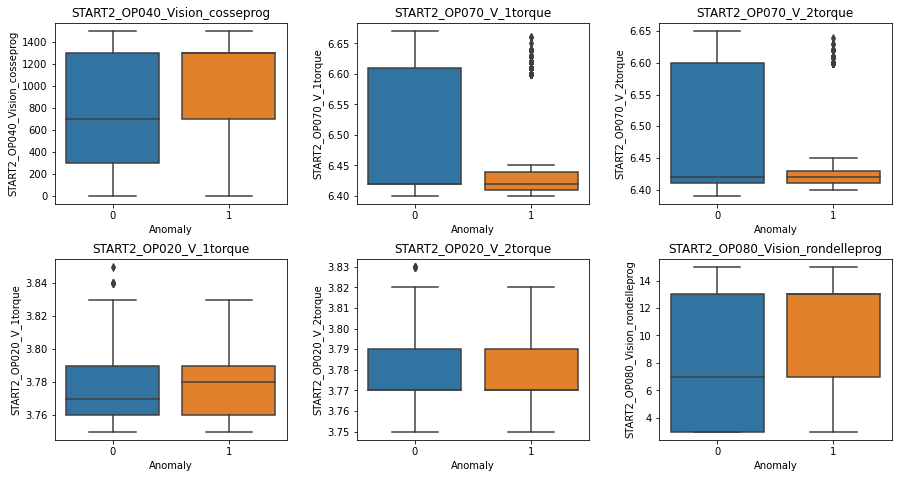

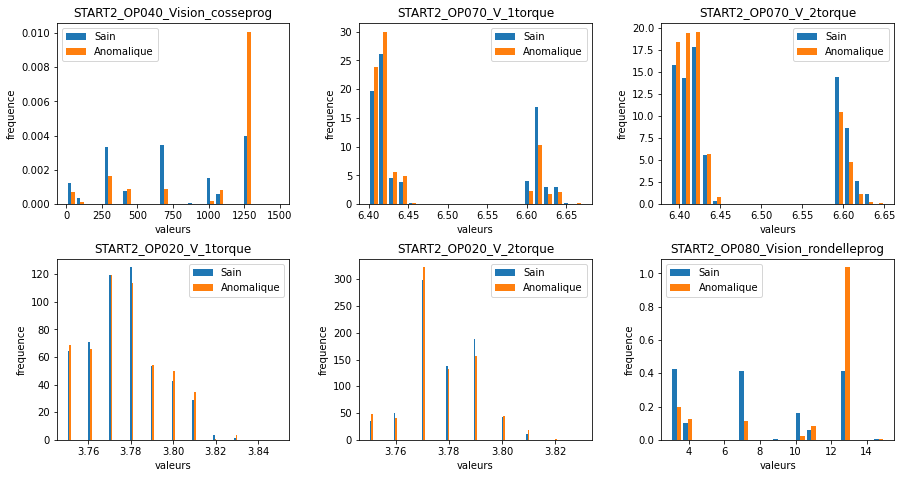

In [36]:
boxplot(df_faibleres)
hist(df_faibleres)

### 2.2.4 Conclusions : 
* Pas de valeur aberrante
* On a redondance entre :
    * START2_OP070_V_1torque et START2_OP070_V_2torque, on ne sélectionne que V_2torque
    * START2_OP040_Vision_cosseprog et START2_OP080_Vision_rondelleprog, on ne sélectionne que START2_OP080_Vision_rondelleprog
* Certaines variables semblent très discriminaintes telles que START2_OP080_Vision_rondelleprog, START2_OP040_Vision_cosseprog, START2_OP100_Capuchon_insertionmesure
* A l'inverse de START2_OP070_V_2torque et START2_OP070_V_1torque ne sont pas à considérer
* START2_OP080_Vision_rondelleprog semble être discret

In [37]:
df[df["START2_OP080_Vision_rondelleprog"]*100!=df["START2_OP040_Vision_cosseprog"]].astype(int)

,START2_OP090_SnapRingPeakForce,START2_OP090_SnapRingMidPointForce,START2_OP090_StartLinePeakForce,START2_OP120_RodageI_mesure,START2_OP070_V_2angle,START2_OP070_V_1angle,START2_OP110_Vissage_M8angle,START2_OP020_V_1angle,START2_OP020_V_2angle,START2_OP090_SnapRingFinalStroke,...,START2_OP080_Vision_rondelleprog,START2_OP070_V_2prog,START2_OP070_V_1prog,START2_OP090_MaxMidForceLimit,START2_OP060_Vision_tirantcouleur,START2_OP050_Vision_palierpresencedouille,START2_OP050_Vision_paliermodel,START2_OP090_MinMidForceLimit,START2_OP110_Vissage_M8prog,Anomaly
1,163,67,18,133,111,106,38,47,50,11,...,3,8,8,140,2,1,1,50,2,0
5,147,75,44,117,157,147,17,34,32,11,...,7,7,7,140,1,1,2,50,1,0
15,189,101,30,136,115,105,31,47,38,12,...,3,8,8,140,2,1,1,50,2,0
36,131,81,25,113,145,158,12,28,37,11,...,7,7,7,140,1,1,2,50,1,0
38,181,107,38,138,123,113,56,47,42,11,...,4,8,8,150,2,1,1,50,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27525,167,78,22,147,106,112,48,37,48,11,...,4,8,8,140,2,1,1,50,1,0
27546,206,95,36,128,131,94,26,41,45,11,...,3,8,8,140,2,1,1,50,2,0
27555,177,112,33,132,124,96,32,50,48,11,...,3,8,8,140,2,1,1,50,2,0
27563,148,76,26,131,120,102,52,42,46,11,...,4,8,8,140,2,1,1,50,1,0


In [38]:
def nf1(df):
    """
    Création d'une nouvelle feature par rapport au type de relation entre  
    START2_OP080_Vision_rondelleprog et START2_OP040_Vision_cosseprog
    """
    Xclean=df.copy()
    Xclean.insert(loc = 0, 
          column = 'nf1', 
          value = (Xclean["START2_OP080_Vision_rondelleprog"]*100!=
                   df["START2_OP040_Vision_cosseprog"]).astype(int))
    return Xclean

In [39]:
def preprocess_faibleres(df):
    """
    Suppression de variable redondante et sans lien avec y
    """
    Xclean=df.copy()
    Xclean.drop(['START2_OP070_V_1torque'],axis=1,inplace=True)
    Xclean.drop(['START2_OP040_Vision_cosseprog'],axis=1,inplace=True)
    Xclean.drop(['START2_OP020_V_2torque','START2_OP020_V_1torque'],axis=1,inplace=True)
    return Xclean

## 2.3 Variables continues

In [40]:
df_hauteres=pd.concat([df[df.columns[df.nunique()>25]],ytrain],axis=1)

### 2.3.1 Recherche de valeurs aberrantes

In [41]:
abberrante(df_hauteres)

,START2_OP090_SnapRingPeakForce,START2_OP090_SnapRingMidPointForce,START2_OP090_StartLinePeakForce,START2_OP120_RodageI_mesure,START2_OP070_V_2angle,START2_OP070_V_1angle,START2_OP110_Vissage_M8angle,START2_OP020_V_1angle,START2_OP020_V_2angle,START2_OP090_SnapRingFinalStroke,START2_OP110_Vissage_M8torque,START2_OP120_RodageU_mesure,START2_OP100_Capuchon_insertionmesure,Anomaly
min,0.0000,0.0000,0.0000,101.9800,75.9,81.900,0.000,19.0,21.3,0.00,0.06,3.05,0.11,0.0
1%,101.1700,59.0100,10.6785,109.2100,95.0,91.885,9.100,25.5,28.0,11.31,9.51,11.97,0.12,0.0
5%,119.9350,63.6600,15.4600,111.8200,102.9,96.600,10.700,27.8,30.5,11.47,9.53,11.97,0.22,0.0
50%,171.9150,82.1350,27.0200,121.7400,141.0,137.800,17.700,36.5,39.6,11.75,12.16,11.97,0.41,0.0
95%,206.6875,112.0175,52.9700,141.9100,165.9,163.500,51.000,51.7,51.3,12.27,12.29,11.97,0.59,0.0
99%,214.8415,117.4600,69.6930,149.5205,175.5,172.500,63.715,54.8,54.2,12.49,12.35,11.98,0.60,1.0
max,237.1700,138.2600,93.8000,206.3700,217.5,208.300,132.700,68.3,67.3,12.58,12.47,12.01,0.60,1.0


In [42]:
df_hauteres[df_hauteres.START2_OP090_SnapRingPeakForce==0]

,START2_OP090_SnapRingPeakForce,START2_OP090_SnapRingMidPointForce,START2_OP090_StartLinePeakForce,START2_OP120_RodageI_mesure,START2_OP070_V_2angle,START2_OP070_V_1angle,START2_OP110_Vissage_M8angle,START2_OP020_V_1angle,START2_OP020_V_2angle,START2_OP090_SnapRingFinalStroke,START2_OP110_Vissage_M8torque,START2_OP120_RodageU_mesure,START2_OP100_Capuchon_insertionmesure,Anomaly
5034,0.0,0.0,0.0,137.98,105.8,101.6,32.4,39.3,45.3,0.0,9.55,11.97,0.54,0
21971,0.0,0.0,0.0,123.99,129.1,123.0,23.2,41.5,36.7,0.0,12.19,11.97,0.12,0


In [43]:
# 2 points éliminés par ce filtre
df_hauteres[df_hauteres.START2_OP090_SnapRingPeakForce!=0].describe(percentiles=[.01,.05,.95,.99])

,START2_OP090_SnapRingPeakForce,START2_OP090_SnapRingMidPointForce,START2_OP090_StartLinePeakForce,START2_OP120_RodageI_mesure,START2_OP070_V_2angle,START2_OP070_V_1angle,START2_OP110_Vissage_M8angle,START2_OP020_V_1angle,START2_OP020_V_2angle,START2_OP090_SnapRingFinalStroke,START2_OP110_Vissage_M8torque,START2_OP120_RodageU_mesure,START2_OP100_Capuchon_insertionmesure,Anomaly
count,27584.000000,27584.000000,27584.000000,27584.000000,27584.000000,27584.000000,27584.000000,27584.000000,27584.000000,27584.000000,27584.000000,27584.000000,27584.000000,27584.000000
mean,164.222128,84.067715,30.447296,124.649057,136.865038,131.755652,22.743184,37.986460,40.137895,11.754876,11.492753,11.958261,0.404124,0.025123
std,29.819402,15.160352,11.813216,10.697088,20.583635,22.006926,12.200055,7.680248,6.488732,0.232767,1.165296,0.264344,0.142138,0.156502
min,90.870000,50.450000,4.290000,101.980000,75.900000,81.900000,0.000000,19.000000,21.300000,8.000000,0.060000,3.050000,0.110000,0.000000
1%,101.198300,59.038300,10.690000,109.210000,95.000000,91.883000,9.100000,25.500000,28.000000,11.310000,9.510000,11.970000,0.120000,0.000000
5%,119.963000,63.670000,15.461500,111.820000,102.900000,96.600000,10.700000,27.800000,30.500000,11.470000,9.530000,11.970000,0.220000,0.000000
50%,171.925000,82.140000,27.020000,121.740000,141.000000,137.800000,17.700000,36.500000,39.600000,11.750000,12.160000,11.970000,0.410000,0.000000
95%,206.688500,112.018500,52.970000,141.910000,165.900000,163.500000,51.000000,51.700000,51.300000,12.270000,12.290000,11.970000,0.590000,0.000000
99%,214.841700,117.460000,69.693400,149.521900,175.500000,172.500000,63.717000,54.800000,54.200000,12.490000,12.350000,11.980000,0.600000,1.000000
max,237.170000,138.260000,93.800000,206.370000,217.500000,208.300000,132.700000,68.300000,67.300000,12.580000,12.470000,12.010000,0.600000,1.000000


In [44]:
df_hauteres[df_hauteres.START2_OP110_Vissage_M8angle==0]

,START2_OP090_SnapRingPeakForce,START2_OP090_SnapRingMidPointForce,START2_OP090_StartLinePeakForce,START2_OP120_RodageI_mesure,START2_OP070_V_2angle,START2_OP070_V_1angle,START2_OP110_Vissage_M8angle,START2_OP020_V_1angle,START2_OP020_V_2angle,START2_OP090_SnapRingFinalStroke,START2_OP110_Vissage_M8torque,START2_OP120_RodageU_mesure,START2_OP100_Capuchon_insertionmesure,Anomaly
14444,176.36,72.39,20.20,139.11,117.7,111.2,0.0,41.5,47.1,11.75,0.07,11.97,0.42,0
17318,144.54,65.30,29.49,122.72,151.4,147.6,0.0,41.6,39.4,12.05,0.06,11.97,0.42,0
24383,215.60,106.87,39.96,112.21,121.2,135.3,0.0,33.5,43.6,11.90,1.11,11.97,0.59,0
26180,138.64,85.84,22.82,137.47,119.9,104.2,0.0,51.7,52.0,11.59,0.16,11.97,0.55,0


In [45]:
# 4 points éliminés par ce filtre
df_hauteres[(df_hauteres.START2_OP090_SnapRingPeakForce!=0)&
           (df_hauteres.START2_OP110_Vissage_M8angle!=0)].describe(percentiles=[.01,.05,.95,.99])

,START2_OP090_SnapRingPeakForce,START2_OP090_SnapRingMidPointForce,START2_OP090_StartLinePeakForce,START2_OP120_RodageI_mesure,START2_OP070_V_2angle,START2_OP070_V_1angle,START2_OP110_Vissage_M8angle,START2_OP020_V_1angle,START2_OP020_V_2angle,START2_OP090_SnapRingFinalStroke,START2_OP110_Vissage_M8torque,START2_OP120_RodageU_mesure,START2_OP100_Capuchon_insertionmesure,Anomaly
count,27580.000000,27580.000000,27580.000000,27580.000000,27580.000000,27580.000000,27580.000000,27580.000000,27580.000000,27580.000000,27580.000000,27580.000000,27580.000000,27580.000000
mean,164.221466,84.067928,30.447634,124.648589,136.866389,131.756693,22.746483,37.985867,40.137114,11.754867,11.494369,11.958259,0.404111,0.025127
std,29.819236,15.160242,11.813682,10.696962,20.584148,22.007331,12.197864,7.680254,6.488639,0.232774,1.157615,0.264363,0.142141,0.156513
min,90.870000,50.450000,4.290000,101.980000,75.900000,81.900000,6.500000,19.000000,21.300000,8.000000,9.500000,3.050000,0.110000,0.000000
1%,101.197900,59.037900,10.690000,109.210000,95.000000,91.879000,9.100000,25.500000,28.000000,11.310000,9.510000,11.970000,0.120000,0.000000
5%,119.959500,63.669500,15.460000,111.820000,102.900000,96.600000,10.700000,27.800000,30.500000,11.470000,9.530000,11.970000,0.220000,0.000000
50%,171.925000,82.140000,27.020000,121.740000,141.000000,137.800000,17.700000,36.500000,39.600000,11.750000,12.160000,11.970000,0.410000,0.000000
95%,206.680500,112.020000,52.970000,141.910500,165.900000,163.500000,51.000000,51.700000,51.300000,12.270000,12.290000,11.970000,0.590000,0.000000
99%,214.832100,117.460000,69.694200,149.524700,175.500000,172.500000,63.721000,54.800000,54.200000,12.490000,12.350000,11.980000,0.600000,1.000000
max,237.170000,138.260000,93.800000,206.370000,217.500000,208.300000,132.700000,68.300000,67.300000,12.580000,12.470000,12.010000,0.600000,1.000000


In [46]:
df_hauteres[df_hauteres.START2_OP090_SnapRingFinalStroke<10].describe()

,START2_OP090_SnapRingPeakForce,START2_OP090_SnapRingMidPointForce,START2_OP090_StartLinePeakForce,START2_OP120_RodageI_mesure,START2_OP070_V_2angle,START2_OP070_V_1angle,START2_OP110_Vissage_M8angle,START2_OP020_V_1angle,START2_OP020_V_2angle,START2_OP090_SnapRingFinalStroke,START2_OP110_Vissage_M8torque,START2_OP120_RodageU_mesure,START2_OP100_Capuchon_insertionmesure,Anomaly
count,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000
mean,100.452632,66.853158,12.930526,124.235000,144.376316,135.207895,18.018421,33.657895,38.444737,9.119737,11.993158,11.970263,0.256053,0.026316
std,28.095103,19.574149,5.571564,5.512815,15.255064,14.037159,9.274197,5.678153,4.815667,2.200763,0.721201,0.001622,0.093593,0.162221
min,0.000000,0.000000,0.000000,114.350000,105.800000,101.600000,7.900000,22.600000,27.200000,0.000000,9.550000,11.970000,0.120000,0.000000
25%,97.222500,65.530000,10.675000,120.215000,136.625000,126.075000,12.200000,29.300000,34.775000,9.560000,12.142500,11.970000,0.230000,0.000000
50%,100.365000,67.730000,12.220000,124.360000,145.900000,136.800000,15.050000,32.600000,38.000000,9.665000,12.185000,11.970000,0.230000,0.000000
75%,106.197500,71.745000,15.380000,128.037500,157.550000,147.025000,21.425000,37.625000,42.250000,9.772500,12.247500,11.970000,0.230000,0.000000
max,158.620000,134.330000,27.660000,137.980000,164.900000,159.900000,57.500000,49.800000,48.100000,9.920000,12.350000,11.980000,0.550000,1.000000


In [47]:
df_hauteres[(df_hauteres.START2_OP090_SnapRingPeakForce!=0)&
           (df_hauteres.START2_OP110_Vissage_M8angle!=0)&
           (df_hauteres.START2_OP090_SnapRingFinalStroke>=10)].describe(percentiles=[.01,.05,.95,.99])

,START2_OP090_SnapRingPeakForce,START2_OP090_SnapRingMidPointForce,START2_OP090_StartLinePeakForce,START2_OP120_RodageI_mesure,START2_OP070_V_2angle,START2_OP070_V_1angle,START2_OP110_Vissage_M8angle,START2_OP020_V_1angle,START2_OP020_V_2angle,START2_OP090_SnapRingFinalStroke,START2_OP110_Vissage_M8torque,START2_OP120_RodageU_mesure,START2_OP100_Capuchon_insertionmesure,Anomaly
count,27544.000000,27544.000000,27544.000000,27544.000000,27544.000000,27544.000000,27544.000000,27544.000000,27544.000000,27544.000000,27544.000000,27544.000000,27544.000000,27544.000000
mean,164.297518,84.085573,30.469590,124.649620,136.854618,131.750519,22.753373,37.992013,40.139511,11.757648,11.493636,11.958244,0.404309,0.025123
std,29.759551,15.156604,11.804545,10.702334,20.589017,22.016137,12.199972,7.680802,6.490281,0.219530,1.157988,0.264536,0.142099,0.156503
min,90.870000,50.450000,5.740000,101.980000,75.900000,81.900000,6.500000,19.000000,21.300000,10.300000,9.500000,3.050000,0.110000,0.000000
1%,101.474300,59.040000,10.744300,109.210000,95.000000,91.843000,9.100000,25.500000,28.000000,11.340000,9.510000,11.970000,0.120000,0.000000
5%,120.241500,63.670000,15.530000,111.820000,102.900000,96.600000,10.700000,27.800000,30.500000,11.470000,9.530000,11.970000,0.220000,0.000000
50%,172.000000,82.155000,27.040000,121.740000,141.000000,137.800000,17.800000,36.600000,39.600000,11.750000,12.160000,11.970000,0.410000,0.000000
95%,206.698500,112.020000,52.970000,141.920000,165.900000,163.500000,51.000000,51.700000,51.300000,12.270000,12.290000,11.970000,0.590000,0.000000
99%,214.835700,117.455700,69.701400,149.549900,175.500000,172.500000,63.757000,54.800000,54.200000,12.490000,12.350000,11.980000,0.600000,1.000000
max,237.170000,138.260000,93.800000,206.370000,217.500000,208.300000,132.700000,68.300000,67.300000,12.580000,12.470000,12.010000,0.600000,1.000000


In [48]:
df_hauteres[(df_hauteres.START2_OP090_SnapRingPeakForce!=0)&
           (df_hauteres.START2_OP110_Vissage_M8angle!=0)&
            (df_hauteres.START2_OP090_SnapRingFinalStroke>=10)&
           (df_hauteres.START2_OP120_RodageU_mesure<10)].describe(percentiles=[.01,.05,.95,.99])

,START2_OP090_SnapRingPeakForce,START2_OP090_SnapRingMidPointForce,START2_OP090_StartLinePeakForce,START2_OP120_RodageI_mesure,START2_OP070_V_2angle,START2_OP070_V_1angle,START2_OP110_Vissage_M8angle,START2_OP020_V_1angle,START2_OP020_V_2angle,START2_OP090_SnapRingFinalStroke,START2_OP110_Vissage_M8torque,START2_OP120_RodageU_mesure,START2_OP100_Capuchon_insertionmesure,Anomaly
count,61.000000,61.00000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000
mean,190.282459,89.63918,25.185410,199.270656,114.037705,105.998361,55.849180,43.386885,44.840984,12.066066,12.084918,6.562951,0.420000,0.180328
std,8.879782,6.50415,4.586969,0.096452,7.823600,6.703345,5.886698,5.983323,4.991439,0.072302,0.037221,1.559974,0.001826,0.387651
min,170.430000,75.47000,20.190000,199.050000,101.300000,94.600000,44.100000,29.200000,35.400000,11.770000,12.010000,3.050000,0.410000,0.000000
1%,171.288000,78.89600,20.208000,199.080000,101.300000,94.660000,44.520000,30.280000,35.640000,11.812000,12.010000,3.560000,0.416000,0.000000
5%,173.380000,81.26000,20.520000,199.120000,104.500000,96.300000,46.300000,32.900000,36.900000,11.920000,12.020000,4.180000,0.420000,0.000000
50%,190.660000,88.75000,23.590000,199.280000,112.600000,105.000000,55.300000,45.700000,45.500000,12.090000,12.090000,6.770000,0.420000,0.000000
95%,201.640000,95.12000,36.110000,199.370000,127.800000,115.200000,65.600000,50.500000,51.900000,12.120000,12.150000,8.480000,0.420000,1.000000
99%,202.728000,117.58000,37.834000,199.576000,137.960000,122.160000,68.600000,51.700000,52.680000,12.124000,12.164000,9.338000,0.424000,1.000000
max,203.520000,117.58000,39.490000,199.780000,140.600000,130.800000,71.300000,51.700000,53.100000,12.130000,12.170000,9.650000,0.430000,1.000000


Pour START2_OP120_RodageU_mesure on voit que les valeurs aberrantes correspondent à une surreprésentation de l'anomalie. 18% d'anomalie si START2_OP120_RodageU_mesure < 10 soit 7 fois plus que la moyenne.

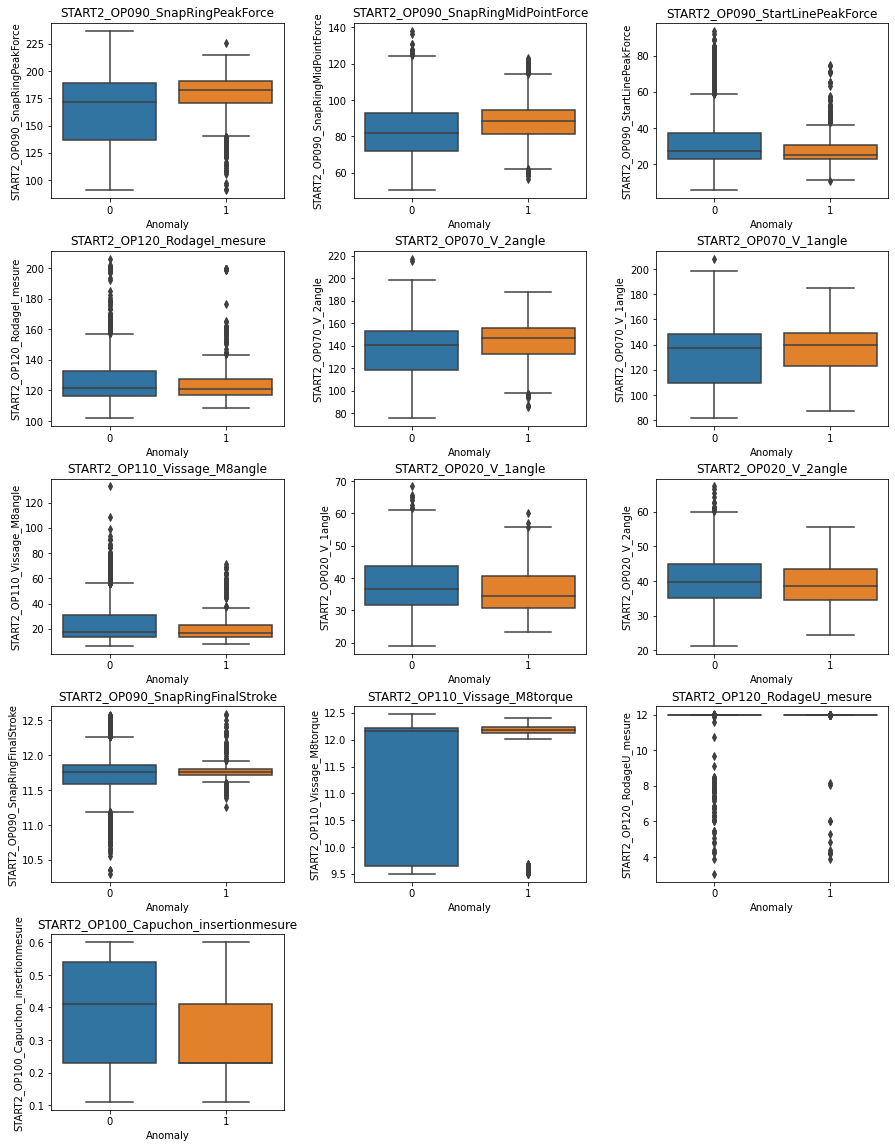

In [49]:
boxplot(df_hauteres[(df_hauteres.START2_OP090_SnapRingPeakForce!=0)&
           (df_hauteres.START2_OP110_Vissage_M8angle!=0)&
            (df_hauteres.START2_OP090_SnapRingFinalStroke>=10)]) # brut
#boxplot(df_continu[df_continu.START2_OP090_SnapRingFinalStroke>9.5]) # pour enlever valeur abberante

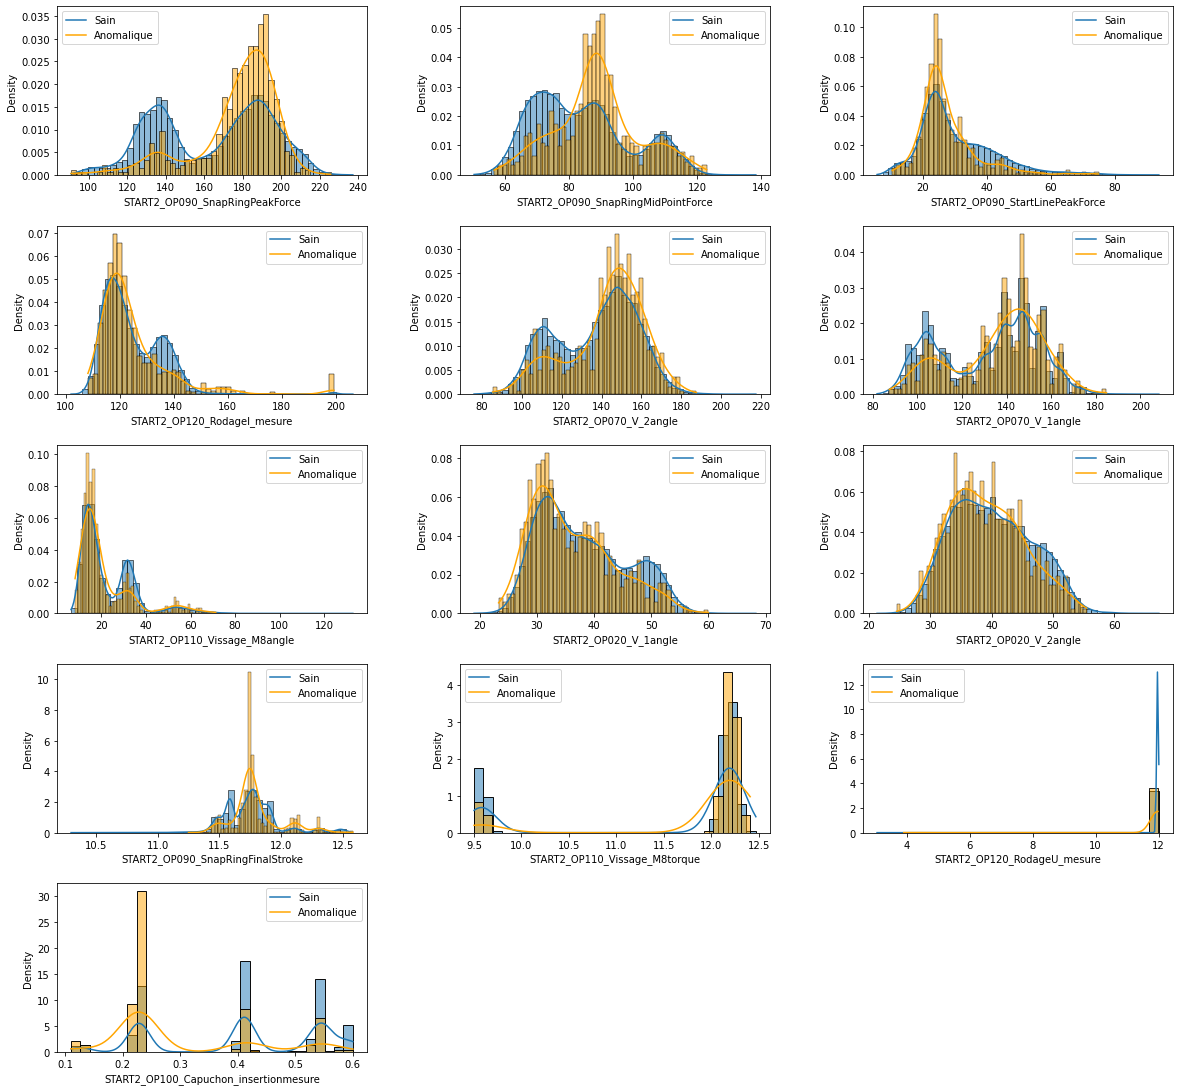

In [50]:
plot_dist(df_hauteres[(df_hauteres.START2_OP090_SnapRingPeakForce!=0)&
           (df_hauteres.START2_OP110_Vissage_M8angle!=0)&
            (df_hauteres.START2_OP090_SnapRingFinalStroke>=10)])

### 2.3.2 Corrélation entre covariables

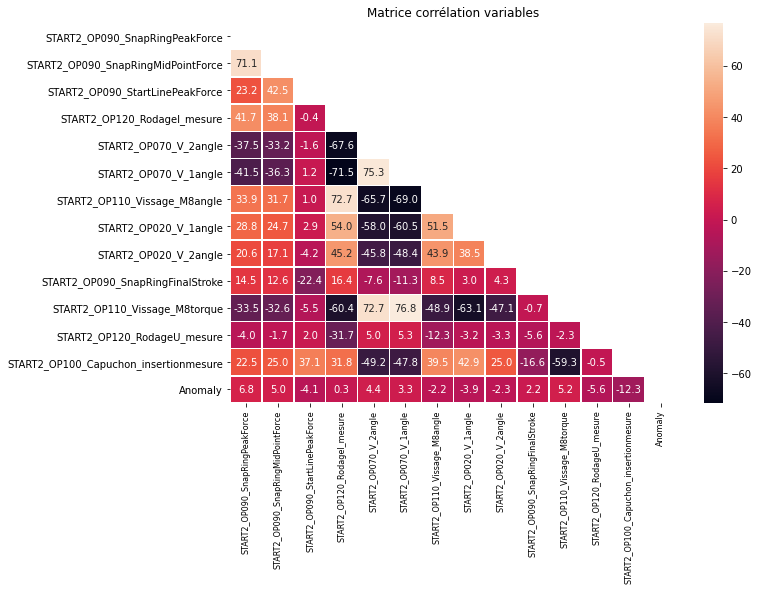

In [51]:
correl_plot(df_hauteres)

### 2.3.3 Conclusions :
* Les variables sont pour la plupart multimodales.
* Pas de dépendance linéaire forte justifiant suppression
* Valeures abberrantes définies à :
    * 0 pour START2_OP090_SnapRingPeakForce (2 points) et START2_OP110_Vissage_M8angle!=0 (4 points)
    * < 10 pour START2_OP090_SnapRingFinalStroke (38 points)
* On observe les meilleures séparations pour START2_OP090_SnapRingPeakForce START2_OP090_SnapRingMidPointForce START2_OP100_Capuchon_insertionmesure START2_OP070_V_2angle

In [52]:
def preprocess_hauteres(df):
    """
    Suppression de variable abberantes
    """
    Xclean = df.copy()
    Xclean = df[(df.START2_OP090_SnapRingPeakForce!=0)&
               (df.START2_OP090_SnapRingFinalStroke>=10)&
                (df.START2_OP110_Vissage_M8angle!=0)
               ]
    return Xclean

### 2.4.1 Contrôle qualité sur les lignes

On regarde si on peut avoir maintenant des doublons sur les observations.

In [53]:
df[(df.drop(["Anomaly"],axis=1).duplicated(keep=False))][["START2_OP090_SnapRingPeakForce","Anomaly"]].describe()[0:3]

,START2_OP090_SnapRingPeakForce,Anomaly
count,654.000000,654.000000
mean,177.537706,0.493884
std,20.755303,0.500345


On s'aperçoit qu'on a 654 observations qui sont des doublons et que ces doublons sont pour **moitié des anomalies**. On va commencer par regarder la nature de ces doublons : paire triplet quadruplet ... ? Pour se faire on fait un group by sur les colonne ayant les plus grand nombre de valeurs différente.

In [54]:
(df.drop(["Anomaly"],axis=1)).columns.tolist()

['START2_OP090_SnapRingPeakForce',
 'START2_OP090_SnapRingMidPointForce',
 'START2_OP090_StartLinePeakForce',
 'START2_OP120_RodageI_mesure',
 'START2_OP070_V_2angle',
 'START2_OP070_V_1angle',
 'START2_OP110_Vissage_M8angle',
 'START2_OP020_V_1angle',
 'START2_OP020_V_2angle',
 'START2_OP090_SnapRingFinalStroke',
 'START2_OP110_Vissage_M8torque',
 'START2_OP120_RodageU_mesure',
 'START2_OP100_Capuchon_insertionmesure',
 'START2_OP040_Vision_cosseprog',
 'START2_OP070_V_1torque',
 'START2_OP070_V_2torque',
 'START2_OP020_V_1torque',
 'START2_OP020_V_2torque',
 'START2_OP080_Vision_rondelleprog',
 'START2_OP070_V_2prog',
 'START2_OP070_V_1prog',
 'START2_OP090_MaxMidForceLimit',
 'START2_OP060_Vision_tirantcouleur',
 'START2_OP050_Vision_palierpresencedouille',
 'START2_OP050_Vision_paliermodel',
 'START2_OP090_MinMidForceLimit',
 'START2_OP110_Vissage_M8prog']

In [55]:
df[(df.drop(["Anomaly"],axis=1).duplicated(keep=False))].groupby(
    ['START2_OP090_SnapRingPeakForce','START2_OP090_SnapRingMidPointForce',]
    ).apply(lambda x: tuple(x.index))

START2_OP090_SnapRingPeakForce  START2_OP090_SnapRingMidPointForce
90.91                           56.71                                 (15749, 23746)
92.12                           72.90                                 (13258, 24054)
108.56                          66.32                                 (13448, 14884)
112.81                          70.72                                 (15102, 21419)
113.85                          59.04                                 (13176, 27024)
                                                                           ...      
205.86                          83.62                                  (2683, 19343)
207.28                          92.12                                  (2441, 12587)
210.45                          105.18                                  (3039, 6581)
214.54                          94.27                                 (10641, 22661)
214.77                          92.47                                  (8821, 14904

On s'aperçoit que les doublons sont constitué de 327 paires (pas de triplet ni de quadruplet). On va regarder la nature de ces doublons pour vérifier si elles sont concordantes ou contradictoires. POur se faire on regarde indirectement en regardant les doublons avec le dataframe incluant l'étiquette.

In [56]:
df[df.duplicated(keep=False)].Anomaly # ici on a intégré l'étiquette

1457     0
5581     0
7561     0
8482     0
14048    0
17642    0
19685    0
26011    0
Name: Anomaly, dtype: int64

On a donc sur les 327 paires de doublons 324 paire de doublons avec des étiquette contradictoire (0,1). Ce qui veut dire qu'on a la moitié de nos données décrites comme anomaliques qui sont des faux positifs (?!).

Avant de considérer le filtrage de ces doublons on regarde si on observe le meme phénomène sur le xtest :

In [57]:
xtest[(xtest.duplicated(keep=False))]

,START2_OP020_V_1angle,START2_OP020_V_1torque,START2_OP020_V_2angle,START2_OP020_V_2torque,START2_OP040_Vision_cosseprog,START2_OP050_Vision_paliermodel,START2_OP050_Vision_palierpresencedouille,START2_OP060_Vision_tirantcouleur,START2_OP070_V_1angle,START2_OP070_V_1prog,...,START2_OP090_SnapRingFinalStroke,START2_OP090_SnapRingMidPointForce,START2_OP090_SnapRingPeakForce,START2_OP090_StartLinePeakForce,START2_OP100_Capuchon_insertionmesure,START2_OP110_Vissage_M8angle,START2_OP110_Vissage_M8prog,START2_OP110_Vissage_M8torque,START2_OP120_RodageI_mesure,START2_OP120_RodageU_mesure
43,47.0,3.75,51.8,3.79,300.0,1.0,1.0,2.0,104.7,8.0,...,11.81,107.25,188.72,45.18,0.54,36.2,2.0,9.63,150.34,11.97
51,30.3,3.79,32.5,3.79,1300.0,2.0,1.0,1.0,146.4,7.0,...,11.53,74.03,138.50,15.18,0.23,16.9,1.0,12.36,116.46,11.97
84,37.7,3.76,39.8,3.78,700.0,2.0,1.0,1.0,151.9,7.0,...,11.59,73.17,126.65,25.62,0.41,16.5,1.0,12.14,113.84,11.97
108,34.1,3.80,43.9,3.79,1300.0,2.0,1.0,1.0,131.3,7.0,...,12.10,69.14,167.19,17.62,0.23,14.7,1.0,12.23,120.97,11.97
109,51.2,3.76,38.3,3.76,300.0,1.0,1.0,2.0,99.9,8.0,...,11.45,83.70,181.45,20.75,0.54,29.4,2.0,9.53,131.09,11.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27203,27.3,3.80,30.1,3.78,1300.0,2.0,1.0,1.0,163.2,7.0,...,11.77,111.30,181.73,32.11,0.23,27.2,1.0,12.15,120.19,11.97
27303,37.3,3.77,51.4,3.77,300.0,1.0,1.0,2.0,104.1,8.0,...,11.40,89.13,170.42,20.95,0.54,36.1,2.0,9.58,136.73,11.97
27372,27.2,3.80,43.6,3.78,1300.0,2.0,1.0,1.0,158.6,7.0,...,11.75,94.89,183.43,25.07,0.22,16.4,1.0,12.24,111.42,11.97
27490,31.9,3.77,33.3,3.80,1300.0,2.0,1.0,1.0,123.9,7.0,...,12.14,65.47,147.21,15.47,0.23,15.8,1.0,12.24,120.85,11.97


In [58]:
xtest[(xtest.duplicated(keep=False))].groupby(
    ['START2_OP090_SnapRingPeakForce','START2_OP090_SnapRingMidPointForce']
    ).apply(lambda x: tuple(x.index))

START2_OP090_SnapRingPeakForce  START2_OP090_SnapRingMidPointForce
91.06                           73.86                                 (5829, 12604)
96.58                           66.82                                  (659, 10923)
102.94                          72.22                                  (6219, 7941)
107.89                          67.88                                 (9363, 13435)
108.28                          59.06                                 (5151, 15899)
                                                                          ...      
207.44                          90.41                                 (8810, 26002)
208.85                          95.95                                 (5302, 10411)
209.54                          88.39                                  (575, 22268)
210.48                          96.75                                  (286, 26942)
212.85                          90.12                                 (9180, 22103)
Length: 3

Sur l'ensemble des paires dupliquées de l'apprentissage, on a seulement 4 paires qui ne sont pas contradictoires. La moitié de notre cortège anomalique est donc en contradiction avec une observation équivalente.

Comme expliqué en avant propos, bien que n'ayant peu de sens le fait même d'être un doublon est donc discriminant en terme d'anomalie dans le cadre de cet exercice puisqu'on retrouve la meme proportion sur le test set. On se retrouve en effet avec une probabilité conditionnelle de près de 0.5 d'être anomalique si on est un doublon !

Comme nous observons le même phénomène sur le test et que notre modèle est évalué sur le test set on ne peut donc pas ignorer cette information et on propose de créer une nouvelle feature binaire en fonction d'être un doublon ou pas.

In [59]:
def nf2(df):
    """
    Création du nouvelle feature qui détecte doublon
    """
    Xclean=df.copy()
    Xclean.insert(loc = 1, 
          column = 'nf2', 
          value = Xclean.drop(['Anomaly'],axis=1).duplicated(keep=False).astype(int))
    return Xclean

In [60]:
def nf2_test(df):
    """
    Création du nouvelle feature qui détecte doublon
    """
    Xclean=df.copy()
    Xclean.insert(loc = 1, 
          column = 'nf2', 
          value = Xclean.duplicated(keep=False).astype(int))
    return Xclean

In [61]:
def preprocess_nf2(df):
    """
    Doublons = faux positif
    """
    Xclean = df.copy()
    Xclean = Xclean.drop(Xclean[(Xclean.nf2==1)&(Xclean.Anomaly==1)].index)
    Xclean.drop(["nf2"],axis=1,inplace=True)
    return Xclean

def preprocess_nf2_bis(df):
    """
    Doublons = pas d'explication > suppression
    """
    Xclean = df.copy()
    Xclean = Xclean[Xclean.nf2==0] 
    Xclean.drop(["nf2"],axis=1,inplace=True)
    return Xclean

### 2.4.2 Vérification distribution xtest xtrain initial

On vérifie en premier lieu si les distritbuions du test et train sont équivalentes.

In [62]:
xtrain_stat=xtrain.reindex(columns = xtrain.nunique().sort_values(ascending=False).index)
xtest_stat=xtest.reindex(columns = xtrain.nunique().sort_values(ascending=False).index)
xtrain_stat=xtrain_stat.iloc[:,0:19]
xtest_stat=xtest_stat.iloc[:,0:19]
xtrain_stat["origin"]="train"
xtest_stat["origin"]="test"
df_stat=pd.concat([xtrain_stat,xtest_stat])
comparatif=df_stat.groupby("origin").agg(['mean','std','min','max'])

In [63]:
comparatif.iloc[:,0::4]

,START2_OP090_SnapRingPeakForce,START2_OP090_SnapRingMidPointForce,START2_OP090_StartLinePeakForce,START2_OP120_RodageI_mesure,START2_OP070_V_2angle,START2_OP070_V_1angle,START2_OP110_Vissage_M8angle,START2_OP020_V_1angle,START2_OP020_V_2angle,START2_OP090_SnapRingFinalStroke,START2_OP110_Vissage_M8torque,START2_OP120_RodageU_mesure,START2_OP100_Capuchon_insertionmesure,START2_OP070_V_1torque,START2_OP040_Vision_cosseprog,START2_OP070_V_2torque,START2_OP020_V_1torque,START2_OP020_V_2torque,START2_OP080_Vision_rondelleprog
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
origin,,,,,,,,,,,,,,,,,,,
test,164.405146,84.091603,30.489893,124.770457,136.729775,131.584021,22.834426,38.065013,40.201769,11.750220,11.481686,11.957519,0.404108,6.484582,739.929423,6.477309,3.775844,3.777410,7.824265
train,164.210221,84.061620,30.445088,124.649516,136.863630,131.754241,22.743551,37.986635,40.137958,11.754024,11.492708,11.958262,0.404118,6.483777,740.714420,6.476801,3.775921,3.777499,7.838215


In [64]:
comparatif.iloc[:,1::4]

,START2_OP090_SnapRingPeakForce,START2_OP090_SnapRingMidPointForce,START2_OP090_StartLinePeakForce,START2_OP120_RodageI_mesure,START2_OP070_V_2angle,START2_OP070_V_1angle,START2_OP110_Vissage_M8angle,START2_OP020_V_1angle,START2_OP020_V_2angle,START2_OP090_SnapRingFinalStroke,START2_OP110_Vissage_M8torque,START2_OP120_RodageU_mesure,START2_OP100_Capuchon_insertionmesure,START2_OP070_V_1torque,START2_OP040_Vision_cosseprog,START2_OP070_V_2torque,START2_OP020_V_1torque,START2_OP020_V_2torque,START2_OP080_Vision_rondelleprog
,std,std,std,std,std,std,std,std,std,std,std,std,std,std,std,std,std,std,std
origin,,,,,,,,,,,,,,,,,,,
test,29.981682,15.165171,11.912396,10.848136,20.600189,22.052623,12.155198,7.687706,6.527841,0.252355,1.173705,0.278905,0.142796,0.095851,443.304762,0.092032,0.016926,0.012723,3.946398
train,29.851088,15.176692,11.815632,10.697002,20.583791,22.006941,12.199751,7.680003,6.488604,0.253366,1.165320,0.264335,0.142146,0.095668,442.872201,0.091749,0.017038,0.012722,3.935215


### 2.4.3 Similitude xtest xtrain initial

On cherche maintenant les doublons possible entre le train et le test.

In [65]:
a=xtest.copy()
b=xtrain.copy()

c=a.merge(b, how="inner")
c.shape

(720, 27)

On observe à nouveau 720 paires dupliquées entre le train et le test.

Cette fois ci au lieu de créer une nouvelle feature, on va créer une fonction qui va récupérer le dictionnaire des correspondances entre doublons du test et du train. On modifiera le résultat de notre prédiction à postériori pour être en cohérence avec la mémoire historique sur échantillons. **On peut effectivement légitiment avancer que la réponse connu d'un individu antérieur identique a plus de crédit que n'importe quel modèle prédictif.**

*Cependant et étrangement avec cet exercice, on rappelle que les doublons sont en très forte proportion des faux positifs. Il suffira donc pour chaque couple de prédire l'inverse du train pour le test.*

In [66]:
a=xtest.copy()
b=xtrain.copy()

a=a.drop_duplicates(keep=False)
b=b.drop_duplicates(keep=False)

a["test_index"]=a.index
b["train_index_tmp"]=b.index

d=pd.concat([a,b],axis=0)

d=d[d.drop(['test_index','train_index_tmp'],axis=1).duplicated(keep=False)]
d=d.sort_values(by=xtest.columns.tolist()).reset_index()
d.iloc[:,-2:]


,test_index,train_index_tmp
0,24433.0,NaN
1,NaN,3557.0
2,24198.0,NaN
3,NaN,13256.0
4,17278.0,NaN
...,...,...
1435,NaN,1571.0
1436,2704.0,NaN
1437,NaN,6723.0
1438,17702.0,NaN


In [67]:
e=d.iloc[:,-2:]
e['train_index']=e['train_index_tmp'].shift(-1)

f=e.iloc[::2,:].drop(['train_index_tmp'],axis=1)
dict(zip(f.test_index, f.train_index))

{24433.0: 3557.0,
 24198.0: 13256.0,
 17278.0: 24510.0,
 23250.0: 27034.0,
 7614.0: 6090.0,
 13661.0: 15351.0,
 24922.0: 18005.0,
 25874.0: 20118.0,
 13929.0: 18128.0,
 9000.0: 16295.0,
 14251.0: 20260.0,
 2763.0: 27567.0,
 16091.0: 6766.0,
 22763.0: 25725.0,
 1485.0: 21538.0,
 5771.0: 6135.0,
 22767.0: 20719.0,
 21017.0: 11256.0,
 18775.0: 27103.0,
 9239.0: 14889.0,
 503.0: 11324.0,
 20578.0: 22439.0,
 14028.0: 4631.0,
 14301.0: 4976.0,
 25769.0: 9692.0,
 25760.0: 1532.0,
 21970.0: 11344.0,
 20196.0: 893.0,
 21940.0: 3573.0,
 16881.0: 20294.0,
 23723.0: 25707.0,
 20526.0: 26376.0,
 23288.0: 13577.0,
 22899.0: 27544.0,
 11672.0: 267.0,
 20559.0: 23413.0,
 9182.0: 9341.0,
 22052.0: 22164.0,
 2474.0: 6332.0,
 2159.0: 2364.0,
 807.0: 2385.0,
 21825.0: 13111.0,
 23929.0: 8478.0,
 23777.0: 2376.0,
 8663.0: 3382.0,
 2739.0: 22046.0,
 14171.0: 8922.0,
 5915.0: 8961.0,
 13260.0: 5739.0,
 20655.0: 1043.0,
 6889.0: 3645.0,
 23191.0: 15274.0,
 4658.0: 22400.0,
 20343.0: 8215.0,
 9397.0: 12138.0,


In [68]:
def catalogue(df1,df2):
    """
    Retourne le dictionnaires des correspondances
    df1 étant le xtest pour les clefs
    df2 étant le xtrain pour les valeurs
    """
    a=df1.copy()
    b=df2.copy()
    
    #on supprime les doublons interne
    a=a.drop_duplicates(keep=False)
    b=b.drop_duplicates(keep=False)
    #on récupère les index
    a["test_index"]=a.index
    b["train_index_tmp"]=b.index
    #on merge les deux 2 dataframe
    d=pd.concat([a,b],axis=0)
    #on ne récupère que les doublons entre train et test
    d=d[d.drop(['test_index','train_index_tmp'],axis=1).duplicated(keep=False)]
    #on trie pour obtenir les paires les unes après les autres
    d=d.sort_values(by=df1.columns.tolist()).reset_index()
    e=d.iloc[:,-2:]
    #on décale la colonne train index pour avoir sur la même ligne les index
    e['train_index']=e['train_index_tmp'].shift(-1)
    f=e.iloc[::2,:].drop(['train_index_tmp'],axis=1)
    correspondance=dict(zip(f.test_index, f.train_index))

    return correspondance

correspondance=catalogue(xtest,xtrain)

qc=0
for k,v in correspondance.items():
    qc=qc+(xtest.iloc[int(k)]==xtrain.iloc[int(v)]).mean()

if qc/len(correspondance) == 1:
    print(f"Test ok \nOn a {len (correspondance)} observations dans le test déjà vu dans le train")
else : 
    print("erreur dans la récupération du catalogue")

Test ok 
On a 720 observations dans le test déjà vu dans le train


![](https://media.giphy.com/media/3o6MbqNPaatT8nnEmk/giphy.gif)

# 3.Modélisation

## 3.1. Split des données et fonction de preprocessing
Compte tenu du déséquilibrage des données on va utiliser l'option stratify pour le split. On utilise aussi une séparation généreuse (50/50) entre train et test pour rester conservateur.

In [69]:
def rechargement():
    """
    chargement des données d'apprentissage brutes
    """
    xtrain = pd.read_csv("../data/xtrain.csv")
    ytrain = pd.read_csv("../data/ytrain.csv")
    df=pd.concat([xtrain,ytrain],axis=1)
    return df

def preprocess_train(df):
    """
    série de transfomration de prétraitement identifiée lors de l'analyse
    """
    Xclean=df.copy()
    Xclean=preprocess_binaire(Xclean)
    Xclean=nf1(Xclean)
    Xclean=preprocess_faibleres(Xclean)
    Xclean=preprocess_hauteres(Xclean)
    Xclean=nf2(Xclean)
    return Xclean

def preprocess_test(df):
    """
    série de transformation de prétraitement identifiée lors de l'analyse
    """
    Xclean=df.copy()
    Xclean=preprocess_binaire(Xclean)
    Xclean=nf1(Xclean)
    Xclean=preprocess_faibleres(Xclean)
    #Xclean=preprocess_hauteres(Xclean) # pas possible de supprimer valeur aberrantes sur le test
    Xclean=nf2_test(Xclean) # adpaté en l'absence d'info anomalie
    return Xclean

def split(df):
    """
    Split des données d'entrainement puor former un nouvel échantillon de test
    """
       
    X_train,X_test,y_train,y_test = train_test_split(df.iloc[:,0:-1],df.Anomaly,
                                                stratify=df.Anomaly,test_size=0.5,
                                                random_state=0)
    print ("Shape des objets : ",X_train.shape,X_test.shape,y_train.shape,y_test.shape)
    print("Pourcentage d'anomalie : dans le train >",round(y_train.mean()*100,3)
      ,"dans le test >",round(y_test.mean()*100,3))
    print("Nombre d'anomalie : dans le train >",y_train.sum(),
      "dans le test >",y_test.sum())
    return X_train,X_test,y_train,y_test

## 3.2 Méthode d'évaluation

In [70]:
def ev_mod(model,X_train,X_test,y_train,y_test):
    """
    Evaluation après split sur apprentissage des performance vu sur la partie test
    """
    model.fit(X_train,y_train)
    print("f1 :",f1_score(y_test, model.predict(X_test)))
    print("roc score :",roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))
    print(confusion_matrix(y_test,model.predict(X_test)))
    print(classification_report(y_test,model.predict(X_test)))
    #plot_roc_curve(model, X_test, y_test);
    false_pos_rate, true_pos_rate, _ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    plt.plot(false_pos_rate, true_pos_rate)


    plt.grid()
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('Taux faux positif', fontsize=16)
    plt.ylabel('Taux vrai positif', fontsize=16)
    plt.title('ROC curve', fontsize=20)

## 3.2 Modèle baseline

Pour débuter, on va construire un modèle de base qui servira de référence pour comparaison.

On choisi donc pour démarrer un modèle linéaire via la regression logistique adaptée à la taille du jeu de données (https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html).

Shape des objets :  (13772, 20) (13772, 20) (13772,) (13772,)
Pourcentage d'anomalie : dans le train > 2.512 dans le test > 2.512
Nombre d'anomalie : dans le train > 346 dans le test > 346
f1 : 0.34816247582205023
roc score : 0.8774414495556461
[[13345    81]
 [  256    90]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     13426
           1       0.53      0.26      0.35       346

    accuracy                           0.98     13772
   macro avg       0.75      0.63      0.67     13772
weighted avg       0.97      0.98      0.97     13772



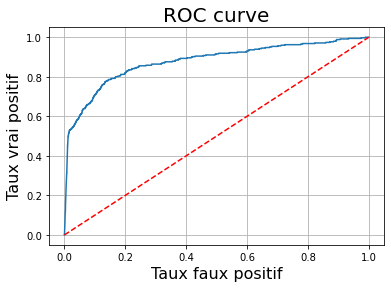

In [71]:
cvs = StratifiedKFold(4)

df_model = rechargement() # brut pas de preprocessing
df_model = preprocess_train(df_model) # élimination redondance val aberrante et création nf1 nf2
#df_model = preprocess_nf2(df_model) # traitement des doublons comme faux positif
#df_model = preprocess_nf2_bis(df_model) # suppression des doublons
X_train,X_test,y_train,y_test=split(df_model)

model_baseline=make_pipeline(StandardScaler(),LogisticRegression(random_state=0,
                                                        solver='liblinear',
                                                        max_iter=1000))

ev_mod(model_baseline,X_train,X_test,y_train,y_test)

On va ensuite affiner nos paramètres via GridSearch. On utilise l'option StratifiedKFold pour prendre garde d'avoir une représentation homogène des anomalies. Par ailleurs, on utilise l'option class_weight qui va nous permettre de prendre en compte l'effet déséquilibré dans les données.

f1 : 0.1771689497716895
roc score : 0.8801445560292384
[[10778  2648]
 [   55   291]]
              precision    recall  f1-score   support

           0       0.99      0.80      0.89     13426
           1       0.10      0.84      0.18       346

    accuracy                           0.80     13772
   macro avg       0.55      0.82      0.53     13772
weighted avg       0.97      0.80      0.87     13772

Wall time: 168 ms


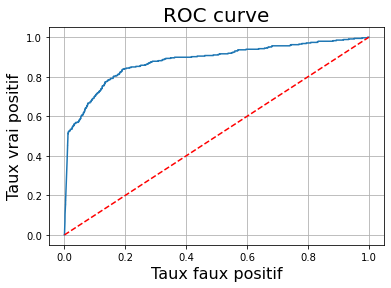

In [72]:
%%time
model_baseline_tune=make_pipeline(MinMaxScaler(),LogisticRegression(random_state=0,
                                                        solver='liblinear',
                                                        class_weight='balanced',
                                                        C=0.13,
                                                        max_iter=1000))

ev_mod(model_baseline_tune,X_train,X_test,y_train,y_test)

In [73]:
#param_grid = dict(standardscaler=[MinMaxScaler(),StandardScaler()],
#                  logisticregression__C=[0.01*(1+4*i) for i in range(20) ])
#grid = GridSearchCV(model_baseline, param_grid,scoring='roc_auc', cv=cvs)
#grid_result = grid.fit(X_train, y_train)

#means = grid_result.cv_results_['mean_test_score']
#stds = grid_result.cv_results_['std_test_score']
#params = grid_result.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
#    print("%f (%f) with: %r" % (mean, stdev, param))

#print(grid.best_score_)
#print(grid.best_params_)

Pour prédire sur le xtest on va donc opérer en 3 temps :
* préprocesser xtest comme pour xtrain (à l'exception du filtrage sur valeurs abberrantes)
* prédire grâce au modèle de regression logistique paramétré
* modifier la prédiction des échantillons test déjà vu dans le train

(27587,)


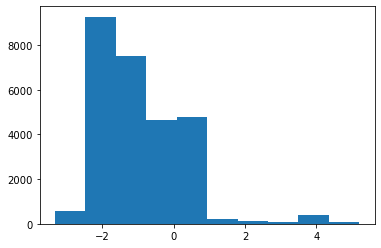

In [75]:
# Prédiction avec modèle régression logistique

#preprocessing de xtest
xtest_transform=preprocess_test(xtest)

#prediction avec modèle
sscore_logistic_tune = model_baseline_tune.decision_function(xtest_transform)
print(sscore_logistic_tune.shape)
#np.savetxt('ytest_challenge_student_logistic_tune_0503.csv', sscore, fmt = '%1.6f', delimiter=',')
plt.hist(sscore_logistic_tune);

# modification à postériori grâce à connaissance des échantillons identiques
sscore_logistic_modif=sscore_logistic_tune.copy()
for k,v in correspondance.items(): # clef index de test et valeur correspondance en train
    #print (int(k),int(v),'>',int(ytrain.iloc[int(v)]))
    if int(ytrain.iloc[int(v)]) == 1:
        sscore_logistic_modif[int(k)]= sscore_logistic_tune.min()
        
    else :
        sscore_logistic_modif[int(k)]= sscore_logistic_tune.max()
        
np.savetxt('../output/ytest_challenge_student_logistic_tune_aprior.csv', sscore_logistic_modif, fmt = '%1.6f', delimiter=',')

La régression logisitque nous permet d'atteindre déjà de bonne performance avec un score en ROC de 0.88 et un temps de calcul rapide. Ce modèle laisse par ailleurs passer assez peu d'anomalie ce qui devrait entrer dans les critère de l'équipementier.

Cette méthode nous permet d'atteindre un score de 0.9953 sur le jeu test disponbile sur http://datachallenge.enst.fr/accounts/login/?next=/. La connaissance à priori des doublons entre le test et le train est la seule explication à cette surperformance.

## 3.3 Méthode d'ensemble

Compte tenu de la nature des variables explicatives (mélange de continu et de discret, distributions multimodales) j'ai choisi de m'orienter vers des méthodes basé sur les arbres qui prennent leurs décision sur des seuils pour améliorer mon modèle de base. Par ailleurs, compte tenu du problème (détection d'anomalie > déséquilibrage de classe), je m'atend à priori à de meilleurs performance via du boosting que du bagging qui risquerait de lisser les données d'entrée et filtrer mes anomalies.

Je teste dans une première passe 3 modèles avec leur paramètres par défaut.

RandomForestClassifier(random_state=0)
f1 : 0.05405405405405405
roc score : 0.879014081899584
[[13340    86]
 [  334    12]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     13426
           1       0.12      0.03      0.05       346

    accuracy                           0.97     13772
   macro avg       0.55      0.51      0.52     13772
weighted avg       0.95      0.97      0.96     13772

AdaBoostClassifier(random_state=0)
f1 : 0.34220532319391633
roc score : 0.8538359270124657
[[13336    90]
 [  256    90]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     13426
           1       0.50      0.26      0.34       346

    accuracy                           0.97     13772
   macro avg       0.74      0.63      0.66     13772
weighted avg       0.97      0.97      0.97     13772

GradientBoostingClassifier(random_state=0)
f1 : 0.09829059829059829
roc score : 0.8895558096661728


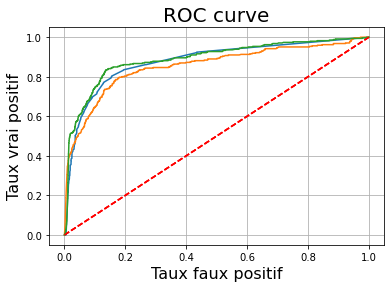

In [76]:
clf_rf = RandomForestClassifier(random_state=0)
clf_ada = AdaBoostClassifier(random_state=0)
clf_gbs = GradientBoostingClassifier(random_state=0)

l_model=[clf_rf,clf_ada,clf_gbs]

for model in l_model:
    print(model)
    ev_mod(model,X_train,X_test,y_train,y_test)

D'après la comparaison de base ci-dessus je vais essayer d'affiner un modèle basé sur le gradient boosting.

f1 : 0.0912863070539419
roc score : 0.8873669758186384
[[13312   114]
 [  324    22]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     13426
           1       0.16      0.06      0.09       346

    accuracy                           0.97     13772
   macro avg       0.57      0.53      0.54     13772
weighted avg       0.96      0.97      0.96     13772

Wall time: 6.33 s


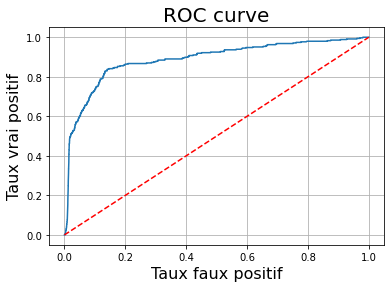

In [77]:
%%time

clf_gbs_tune = GradientBoostingClassifier(random_state=0,
                                          learning_rate=0.1,
                                        max_depth=3,
                                          n_estimators=150
                                         )
ev_mod(clf_gbs_tune,X_train,X_test,y_train,y_test)

In [78]:
#cvs = StratifiedKFold(4)
#param_grid_grad = dict(learning_rate=[0.01,0.1,1,10,100])
#param_grid_grad = dict(n_estimators=[50*(1+2*i)for i in range(5)])
#param_grid_grad = dict(max_depth=[2,3,4])


#grid = GridSearchCV(clf_gbs_tune, param_grid_grad,scoring='roc_auc', cv=cvs)
#grid_result = grid.fit(X_train, y_train)
#print(grid.best_score_)
#print(grid.best_params_)

#means = grid_result.cv_results_['mean_test_score']
#stds = grid_result.cv_results_['std_test_score']
#params = grid_result.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
#    print("%f (%f) with: %r" % (mean, stdev, param))

Enfin je teste un modèle basé sur du Xgboost qui présente l'avantage (en plus du temps de calcul) d'avoir une option prenant en compte le déséquilibrage des classes.

C:\Users\Hp\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:04:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
f1 : 0.09012875536480686
roc score : 0.8669669926955634
[[13327    99]
 [  325    21]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     13426
           1       0.17      0.06      0.09       346

    accuracy                           0.97     13772
   macro avg       0.58      0.53      0.54     13772
weighted avg       0.96      0.97      0.96     13772



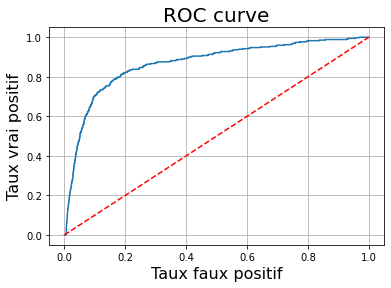

In [79]:
clf_xgb=XGBClassifier(random_state=0)
ev_mod(clf_xgb,X_train,X_test,y_train,y_test)

C:\Users\Hp\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:04:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
f1 : 0.46841294298921415
roc score : 0.8956412973188939
[[13275   151]
 [  194   152]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     13426
           1       0.50      0.44      0.47       346

    accuracy                           0.97     13772
   macro avg       0.74      0.71      0.73     13772
weighted avg       0.97      0.97      0.97     13772

Wall time: 719 ms


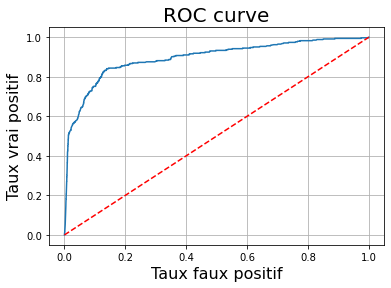

In [80]:
%%time
clf_xgb_tune=XGBClassifier(random_state=0,
                           scale_pos_weight=5,
                           max_depth=2,eta=0.1)#gbtree, gblinear or dart
ev_mod(clf_xgb_tune,X_train,X_test,y_train,y_test)

In [81]:
#param_grid_grad = dict(scale_pos_weight=[i*2 for i in range(50)])
#param_grid_grad = dict(learning_rate=[0.05*i for i in range (1,5)])
#param_grid_grad = dict(max_depth=range(1,6))

#grid = GridSearchCV(clf_xgb_tune, param_grid_grad,scoring='roc_auc', cv=cvs)
#grid_result = grid.fit(X_train, y_train)

#means = grid_result.cv_results_['mean_test_score']
#stds = grid_result.cv_results_['std_test_score']
#params = grid_result.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
#    print("%f (%f) with: %r" % (mean, stdev, param))

#print(grid.best_score_)
#print(grid.best_params_)

In [82]:
clf_xgb_tune.fit(X_train,y_train)

Xpositif=X_train[y_train==1]
Xnegatif=X_train[y_train==0]
print(Xpositif.shape)
print(Xnegatif.shape)

sscorepositif = clf_xgb_tune.predict_proba(Xpositif).T[1]
print("score max pour positif observé",sscorepositif.max())
sscorenegatif = clf_xgb_tune.predict_proba(Xnegatif).T[1]
print("score min pour négatif observé",sscorenegatif.min())

C:\Users\Hp\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:04:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
(346, 20)
(13426, 20)
score max pour positif observé 0.91589487
score min pour négatif observé 0.005133049


In [83]:
# Prédiction avec modèle xgboost

xtest_transform=preprocess_test(xtest)
sscore = clf_xgb_tune.predict_proba(xtest_transform).T[1]
print(sscore.shape)
#np.savetxt('ytest_challenge_student_xgbs_tune_bkcup.csv', sscore, fmt = '%1.6f', delimiter=',')

sscore_modif=sscore.copy()

for k,v in correspondance.items(): # clef index de test et valeur correspondance en train
    #print (int(k),int(v),'>',int(ytrain.iloc[int(v)]))
    if int(ytrain.iloc[int(v)]) == 1:
        sscore_modif[int(k)]= 0
        
    else :
        sscore_modif[int(k)]= 1

np.savetxt('../output/ytest_challenge_student_xgbs_tune_aprior.csv', sscore_modif, fmt = '%1.6f', delimiter=',')


(27587,)


**Conclusions :**

* Le modèle le plus performant que j'ai trouvé après validation croisée sur le jeu de donnée d'entrainement est le Xgboost avec un ROC de 0.896 suivi du gradient boosting 0.885. Une simple régression logistique apporte déjà un ROC de 0.880.
* D'un point de vue performance en temps de calcul, la régression logistique (198 ms) semble bien plus intéressante suivi du Xgboost (760 ms). Le gradient boosting semble particulièrement gourmand en temps de calcul (4 620 ms).
* En fonction du cahier des charges de l'équipementier, on pourrait par ailleurs trouver un autre avantage au modèle en sortie de regression logistique c'est **son fort recall sur les anomalies.** Si celle ci est plus conservatrice entrainant une vérification à postériori 17 fois plus importante que le Xgboost (2648 faux postif vs 150) elle détecte 85% des anomalies contre 56% pour le Xgboost. Ce choix est évidemment dirigé par les critères qualité de l'entreprise.


* Sur le jeu de données test, le modèle en sortie de la regression logsitique m'a fourni un ROC de 0.9953 vs 0.9950 pour le Xboost.
* Bien évidemment le gain en score des ces modèles entre le train et le test, provient de la connaissance à priori de la moitié des anomalies puisqu'il s'agit des doublons entre le train et le test. Ces échantillons représentant la moitié du cortège d'anomalie sur le train il me semble que la part de gain obtenu via un algorithme est alors négligeable.

* Si ma compréhension du dataset et de ce découpage en amont entre test et train s'avère exact, on peut pousser la prédiction à avancer que n'importe quel modèle commetra au moins 353 erreurs de prédictions dans les doublons internes au jeu xtest dont on peut retrouver les indices ci-dessous. Ces 353 erreurs constituent donc une erreur minimum.

In [84]:
# A vérifier avec les étiquettes du xtest ?
print(xtest[xtest.duplicated(keep=False)].index.shape)
xtest[xtest.duplicated(keep=False)].index

(706,)


Int64Index([   43,    51,    84,   108,   109,   177,   206,   237,   286,
              327,
            ...
            26926, 26942, 27036, 27084, 27189, 27203, 27303, 27372, 27490,
            27566],
           dtype='int64', length=706)

# Epilogue

Enfin, pour avoir une meilleur idée de l'influence de la dépendance entre jeu test et train et de l'importance des doublons sur ce datachallenge il n'est pas inintéressant de regarder la distribution des scores obtenus par les étudiants en l'état le vendredi 5 mars à 21H00.

On voit clairement 3 paliers. Il est fort à parier que le premier saut entre 0.8 et 0.9 correspond aux étudiants ayant intégré le fait d'être un doublon comme feature. Même si celui ci a peu de sens, il est prépondérant puisqu'il amène une probabilité conditionnelle extrême en comparaison des autres covariables. Le second palier entre 0.9 et > à 0.95 doivent correspondre aux étudiants ayant pris en compte les doublons entre train et test (ce profil est tout du moins ce que j'ai observé personellement).

Enfin il est évident que construit tel quel, ces modèles ne pourront performer sur des nouvelles observations sauf si celle ci comportent des doublons ayant une même distribution.

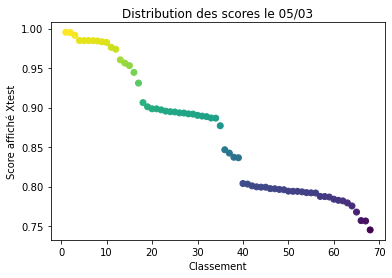

In [85]:
resutlat_datachallenge=np.array([0.995433393,0.995055633,0.991615153,0.984955211,0.984892182,0.984887102,0.984762806,0.984352495,0.983323191,0.98252579,0.976321772,0.9739305,0.960452835,0.956420525,0.953160425,0.94459354,0.931069225,0.906334326,0.901012924,0.898499222,0.898465427,0.89714337,0.895556445,0.894818029,0.894506512,0.89333021,0.893173777,0.892098135,0.89182259,0.890228823,0.889290538,0.888595248,0.88687646,0.886702611,0.877041942,0.846662617,0.842462263,0.837178906,0.836540218,0.803912058,0.803210962,0.8009472,0.799696465,0.799309375,0.79924054,0.797449704,0.797260098,0.796451397,0.796048342,0.794258231,0.7940962,0.794027781,0.793379866,0.792378345,0.792124259,0.791927707,0.787583568,0.787416043,0.786836859,0.784060467,0.782682637,0.781949612,0.779358056,0.775498039,0.767791481,0.756975036,0.756484591,0.74517459
                                ])
plt.scatter(np.linspace(1,len(resutlat_datachallenge),len(resutlat_datachallenge))
            ,resutlat_datachallenge,c=resutlat_datachallenge)
plt.title("Distribution des scores le 05/03")
plt.xlabel("Classement")
plt.ylabel("Score affiché Xtest");